# PCA and Correlation Analysis

### Performs correlation analysis between numerical and categorical variables with the target variable `YieldStrength`.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, chi2_contingency
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
try:
    plt.style.use('seaborn-v0_8')
except:
    try:
        plt.style.use('seaborn')
    except:
        plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


## Load Data


In [ ]:
# Load the data
df = pd.read_csv("../data/data_imputed_2025_11_11.csv")

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (1652, 48)

Columns: ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb', 'Current', 'Voltage', 'AC_DC', 'ElectrodePolarity', 'HeatInput', 'InterpassTemp', 'WeldType', 'YieldStrength', 'UTS', 'Elongation', 'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50', 'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite', 'FerriteCarbide', 'WeldID', 'MechanicalTestDone', 'PrimaryFerrite_missing', 'Ferrite2ndPhase_missing', 'AcicularFerrite_missing', 'Martensite_missing', 'FerriteCarbide_missing']

First few rows:


,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,AcicularFerrite,Martensite,FerriteCarbide,WeldID,MechanicalTestDone,PrimaryFerrite_missing,Ferrite2ndPhase_missing,AcicularFerrite_missing,Martensite_missing,FerriteCarbide_missing
0,0.037,0.30,0.65,0.008,0.012,0.0,1.308508,0.541548,0.063321,0.202337,...,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw,1,1,1,1,1,1
1,0.037,0.30,0.65,0.008,0.012,0.0,1.308508,0.541548,0.063321,0.202337,...,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch,1,1,1,1,1,1
2,0.037,0.30,0.65,0.008,0.012,0.0,1.308508,0.541548,0.063321,0.202337,...,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht,1,1,1,1,1,1
3,0.037,0.31,1.03,0.007,0.014,0.0,1.040208,0.461698,0.099845,0.190271,...,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw,1,1,1,1,1,1
4,0.037,0.31,1.03,0.007,0.014,0.0,1.040208,0.461698,0.099845,0.190271,...,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch,1,0,0,0,0,0


## Define Variables

Automatically detect:
- **Numerical variables**: All numeric columns - target - categorical variables - non-numeric columns
- **Categorical variables**: AC_DC, ElectrodePolarity, WeldType
- **Target**: YieldStrength


In [12]:
# Define target and categorical variables
TARGET = "YieldStrength"
CATEGORICAL_VARS = ["AC_DC", "ElectrodePolarity", "WeldType"]

# Check if target exists
if TARGET not in df.columns:
    raise ValueError(f"Target variable '{TARGET}' not found in dataset!")

# Automatically detect numerical variables
# All columns - target - categorical - non-numeric columns (like WeldID, flags, etc.)
all_columns = df.columns.tolist()

# Identify numeric columns (int64, float64, etc.)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclude target, categorical, and non-numeric columns
# Also exclude columns that are clearly not features (WeldID, MechanicalTestDone, missing flags)
columns_to_exclude = [TARGET] + CATEGORICAL_VARS + \
                     ['WeldID', 'MechanicalTestDone'] + \
                     [col for col in all_columns if '_missing' in col]

# Filter exclusion list to only include columns that exist
columns_to_exclude = [col for col in columns_to_exclude if col in all_columns]

# Get numerical variables: numeric columns that are not in the exclusion list
NUMERICAL_VARS = [col for col in numeric_columns if col not in columns_to_exclude]

# Filter categorical variables to only include columns that exist in the dataset
CATEGORICAL_VARS = [var for var in CATEGORICAL_VARS if var in df.columns]

print(f"Total columns in dataset: {len(all_columns)}")
print(f"\nNumeric columns detected: {len(numeric_columns)}")
print(f"\nColumns excluded: {columns_to_exclude}")
print(f"\nNumerical variables ({len(NUMERICAL_VARS)}):")
print(NUMERICAL_VARS)
print(f"\nCategorical variables ({len(CATEGORICAL_VARS)}): {CATEGORICAL_VARS}")
print(f"\nTarget: {TARGET}")

# Verify that we have variables to analyze
if len(NUMERICAL_VARS) == 0:
    raise ValueError("No numerical variables found! Please check the dataset and exclusion list.")
if len(CATEGORICAL_VARS) == 0:
    print("Warning: No categorical variables found in the dataset.")



Total columns in dataset: 48

Numeric columns detected: 44

Columns excluded: ['YieldStrength', 'AC_DC', 'ElectrodePolarity', 'WeldType', 'WeldID', 'MechanicalTestDone', 'PrimaryFerrite_missing', 'Ferrite2ndPhase_missing', 'AcicularFerrite_missing', 'Martensite_missing', 'FerriteCarbide_missing']

Numerical variables (37):
['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb', 'Current', 'Voltage', 'HeatInput', 'InterpassTemp', 'UTS', 'Elongation', 'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50', 'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite', 'FerriteCarbide']

Categorical variables (3): ['AC_DC', 'ElectrodePolarity', 'WeldType']

Target: YieldStrength


## Data Preprocessing

Filter data to only include rows where the target is not missing for correlation analysis.


In [13]:
# Filter data where target is not missing
df_analysis = df[df[TARGET].notna()].copy()

print(f"Original dataset shape: {df.shape}")
print(f"Analysis dataset shape (with target): {df_analysis.shape}")
print(f"\nMissing values in numerical variables:")
missing_num = df_analysis[NUMERICAL_VARS].isnull().sum()
missing_num_nonzero = missing_num[missing_num > 0]
if len(missing_num_nonzero) > 0:
    print(missing_num_nonzero)
else:
    print("No missing values in numerical variables")

print(f"\nMissing values in categorical variables:")
missing_cat = df_analysis[CATEGORICAL_VARS].isnull().sum()
missing_cat_nonzero = missing_cat[missing_cat > 0]
if len(missing_cat_nonzero) > 0:
    print(missing_cat_nonzero)
else:
    print("No missing values in categorical variables")


Original dataset shape: (1652, 48)
Analysis dataset shape (with target): (757, 48)

Missing values in numerical variables:
PrimaryFerrite     757
Ferrite2ndPhase    757
AcicularFerrite    757
Martensite         757
FerriteCarbide     757
dtype: int64

Missing values in categorical variables:
No missing values in categorical variables


## Correlation Analysis: Numerical Variables vs Target

### 1. Pearson Correlation (Linear Relationships)


In [ ]:
# Calculate Pearson correlation coefficients
pearson_correlations = []
pearson_pvalues = []

for var in NUMERICAL_VARS:
    # Remove missing values for this variable
    data_subset = df_analysis[[var, TARGET]].dropna()
    if len(data_subset) > 3:  # Need at least 3 points for correlation
        corr, pval = pearsonr(data_subset[var], data_subset[TARGET])
        pearson_correlations.append({
            'Variable': var,
            'Correlation': corr,
            'P-value': pval,
            'Significant': pval < 0.05
        })

pearson_df = pd.DataFrame(pearson_correlations).sort_values('Correlation', key=abs, ascending=False)
print("Pearson Correlation with YieldStrength:")
print(pearson_df.to_string(index=False))


Pearson Correlation with YieldStrength:
     Variable  Correlation       P-value  Significant
          UTS     0.836680 1.364422e-199         True
   Elongation    -0.618738  3.517943e-81         True
   CharpyTemp     0.596378  4.221734e-74         True
 CharpyImpact    -0.513855  3.064522e-52         True
ReductionArea    -0.452152  2.036978e-39         True
           Nb     0.351981  1.690829e-23         True
           Mo     0.273768  1.762869e-14         True
            N     0.244151  9.780452e-12         True
           Mn     0.228936  1.850088e-10         True
            C     0.194987  6.376071e-08         True
            P     0.191211  1.150381e-07         True
     Hardness     0.178618  7.569506e-07         True
            V     0.138356  1.341273e-04         True
      Voltage     0.113242  1.804938e-03         True
           Sn    -0.111103  2.203842e-03         True
            S     0.108807  2.720955e-03         True
      Current     0.100925  5.447255e-03  

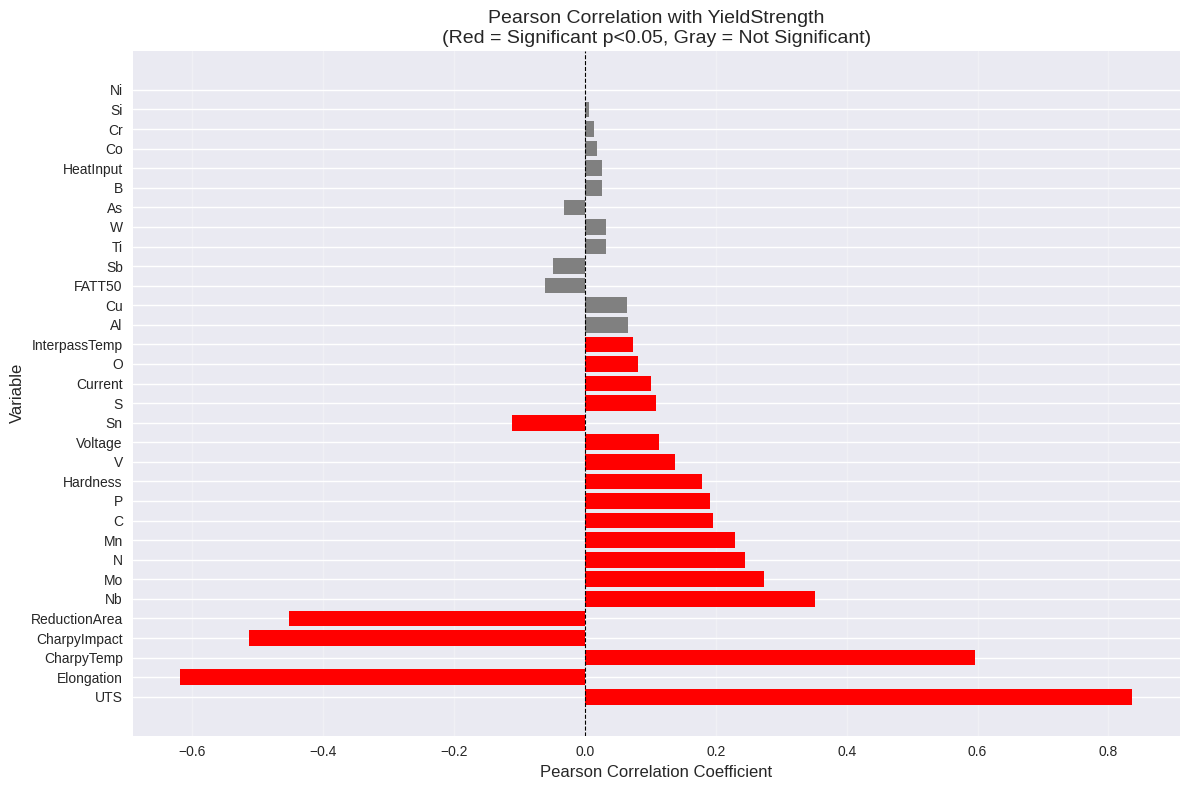

In [15]:
# Plot Pearson correlations
plt.figure(figsize=(12, 8))
colors = ['red' if p < 0.05 else 'gray' for p in pearson_df['P-value']]
plt.barh(range(len(pearson_df)), pearson_df['Correlation'], color=colors)
plt.yticks(range(len(pearson_df)), pearson_df['Variable'])
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('Pearson Correlation with YieldStrength\n(Red = Significant p<0.05, Gray = Not Significant)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### 2. Spearman Correlation (Monotonic Relationships)


In [16]:
# Calculate Spearman correlation coefficients
spearman_correlations = []
spearman_pvalues = []

for var in NUMERICAL_VARS:
    # Remove missing values for this variable
    data_subset = df_analysis[[var, TARGET]].dropna()
    if len(data_subset) > 3:  # Need at least 3 points for correlation
        corr, pval = spearmanr(data_subset[var], data_subset[TARGET])
        spearman_correlations.append({
            'Variable': var,
            'Correlation': corr,
            'P-value': pval,
            'Significant': pval < 0.05
        })

spearman_df = pd.DataFrame(spearman_correlations).sort_values('Correlation', key=abs, ascending=False)
print("Spearman Correlation with YieldStrength:")
print(spearman_df.to_string(index=False))


Spearman Correlation with YieldStrength:
     Variable  Correlation       P-value  Significant
          UTS     0.885939 3.952040e-254         True
   CharpyTemp     0.715752 7.673247e-120         True
   Elongation    -0.661423  2.083331e-96         True
 CharpyImpact    -0.574697  9.499930e-68         True
     Hardness     0.564880  5.026445e-65         True
ReductionArea    -0.560426  8.073578e-64         True
       FATT50    -0.516950  5.909754e-53         True
           Nb     0.343823  1.980856e-22         True
           Mn     0.265583  1.095014e-13         True
            V     0.231027  1.250109e-10         True
           Mo     0.202463  1.913996e-08         True
            N     0.178873  7.296106e-07         True
            C     0.160828  8.722547e-06         True
           Cr     0.160658  8.918301e-06         True
           As    -0.160657  8.919374e-06         True
            P     0.157694  1.307410e-05         True
           Sn    -0.126146  5.034726e-04 

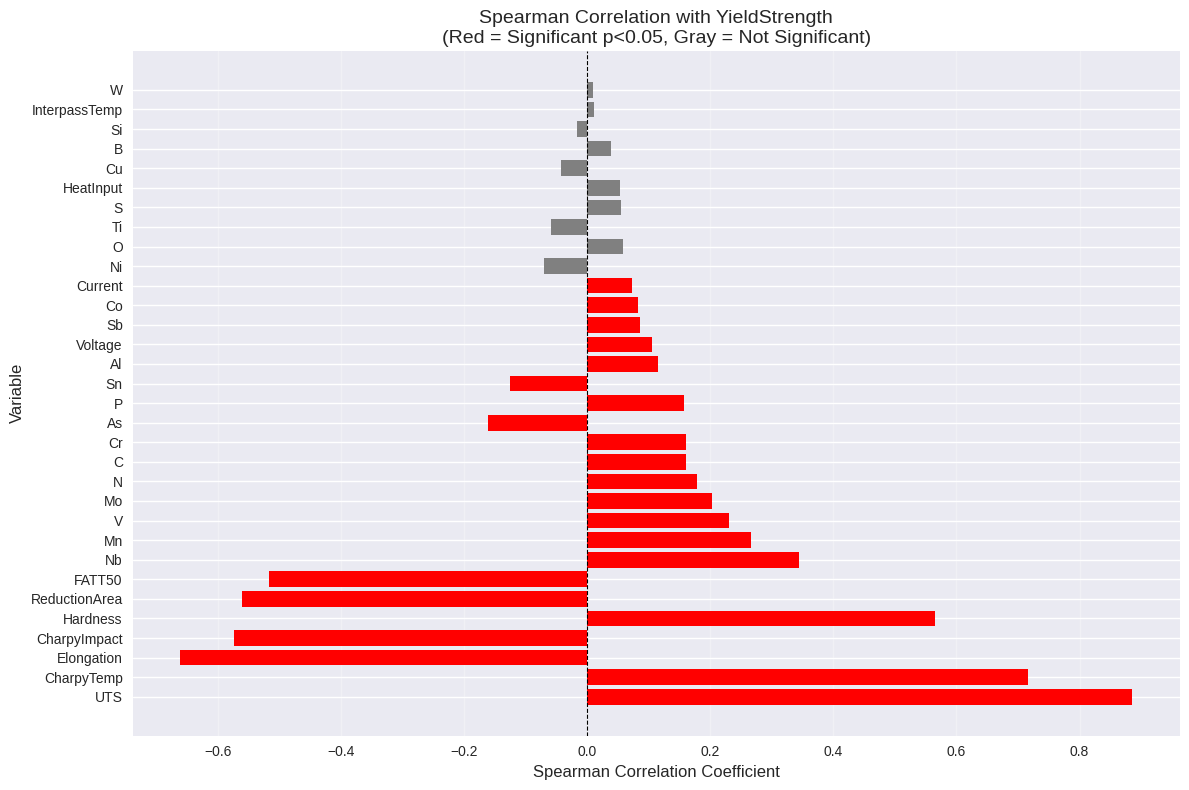

In [17]:
# Plot Spearman correlations
plt.figure(figsize=(12, 8))
colors = ['red' if p < 0.05 else 'gray' for p in spearman_df['P-value']]
plt.barh(range(len(spearman_df)), spearman_df['Correlation'], color=colors)
plt.yticks(range(len(spearman_df)), spearman_df['Variable'])
plt.xlabel('Spearman Correlation Coefficient', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.title('Spearman Correlation with YieldStrength\n(Red = Significant p<0.05, Gray = Not Significant)', fontsize=14)
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


### 3. Correlation Matrix Heatmap (Numerical Variables)


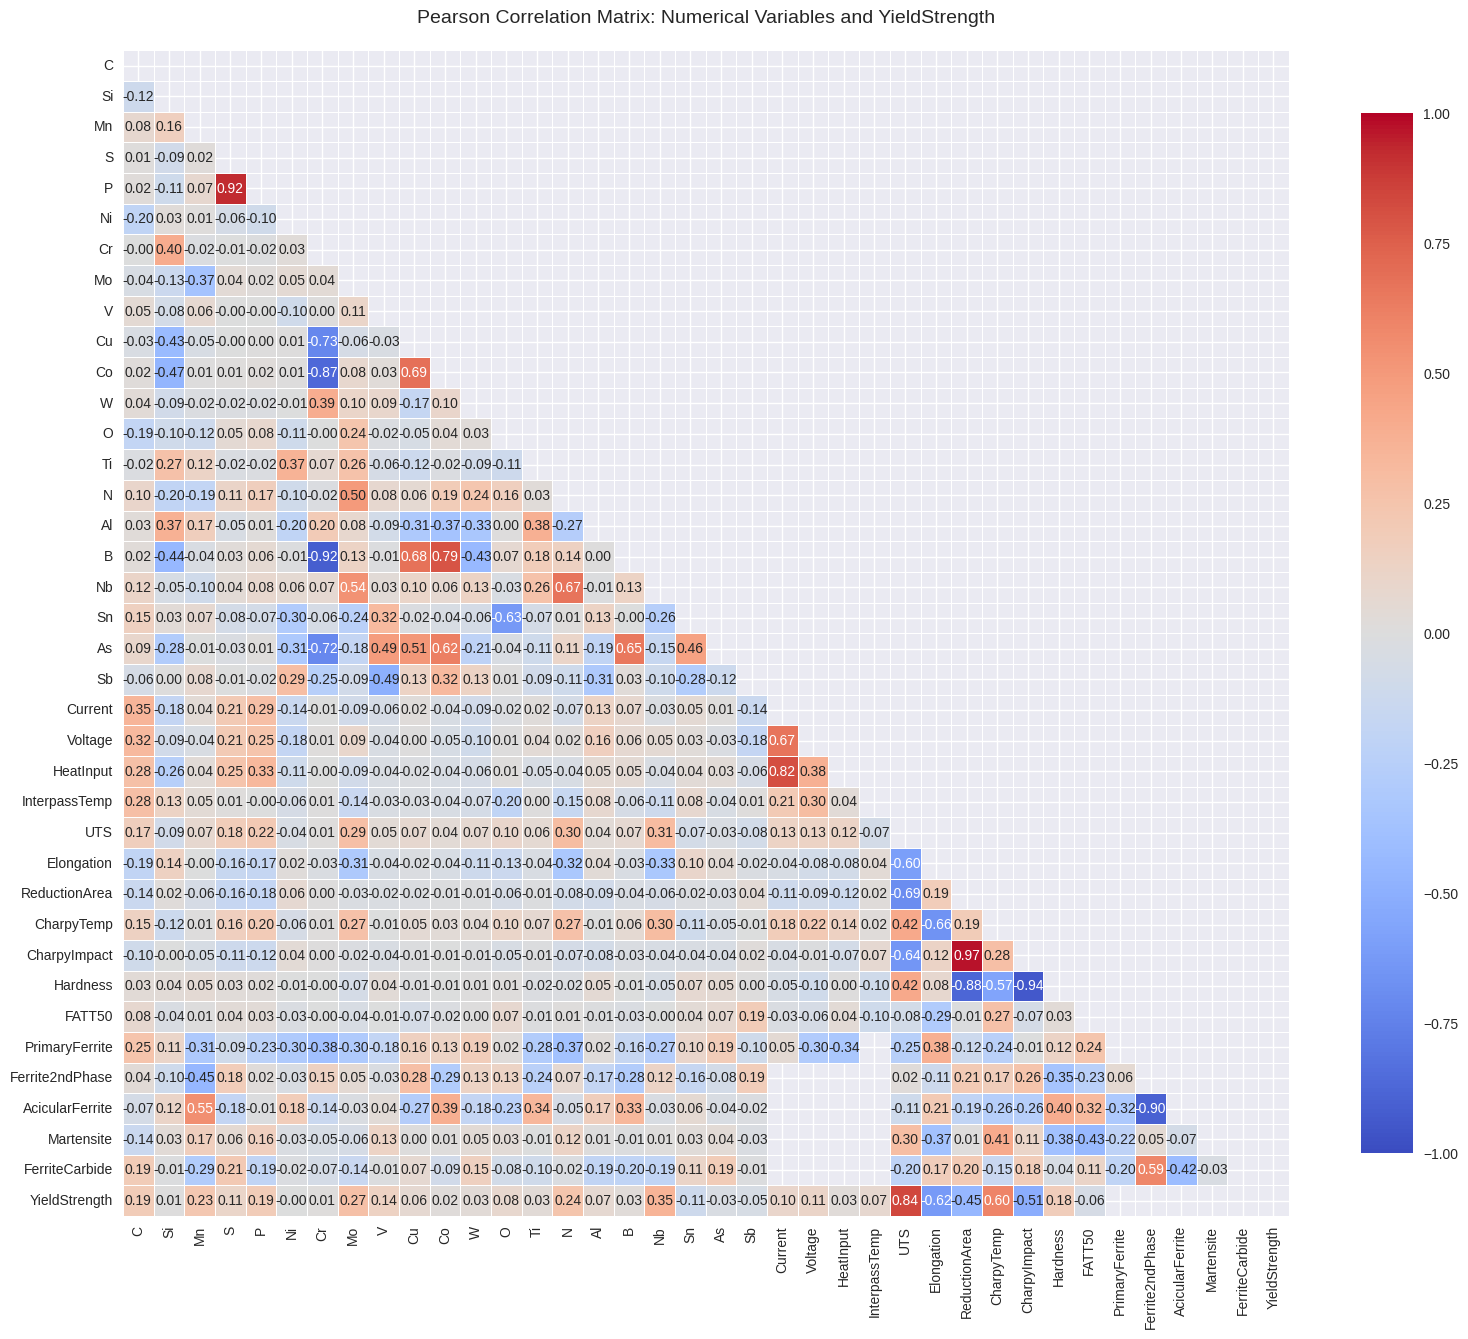

In [18]:
# Create correlation matrix for all numerical variables including target
numerical_with_target = NUMERICAL_VARS + [TARGET]
corr_matrix = df_analysis[numerical_with_target].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Pearson Correlation Matrix: Numerical Variables and YieldStrength', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


### 4. Top Correlated Variables with Target


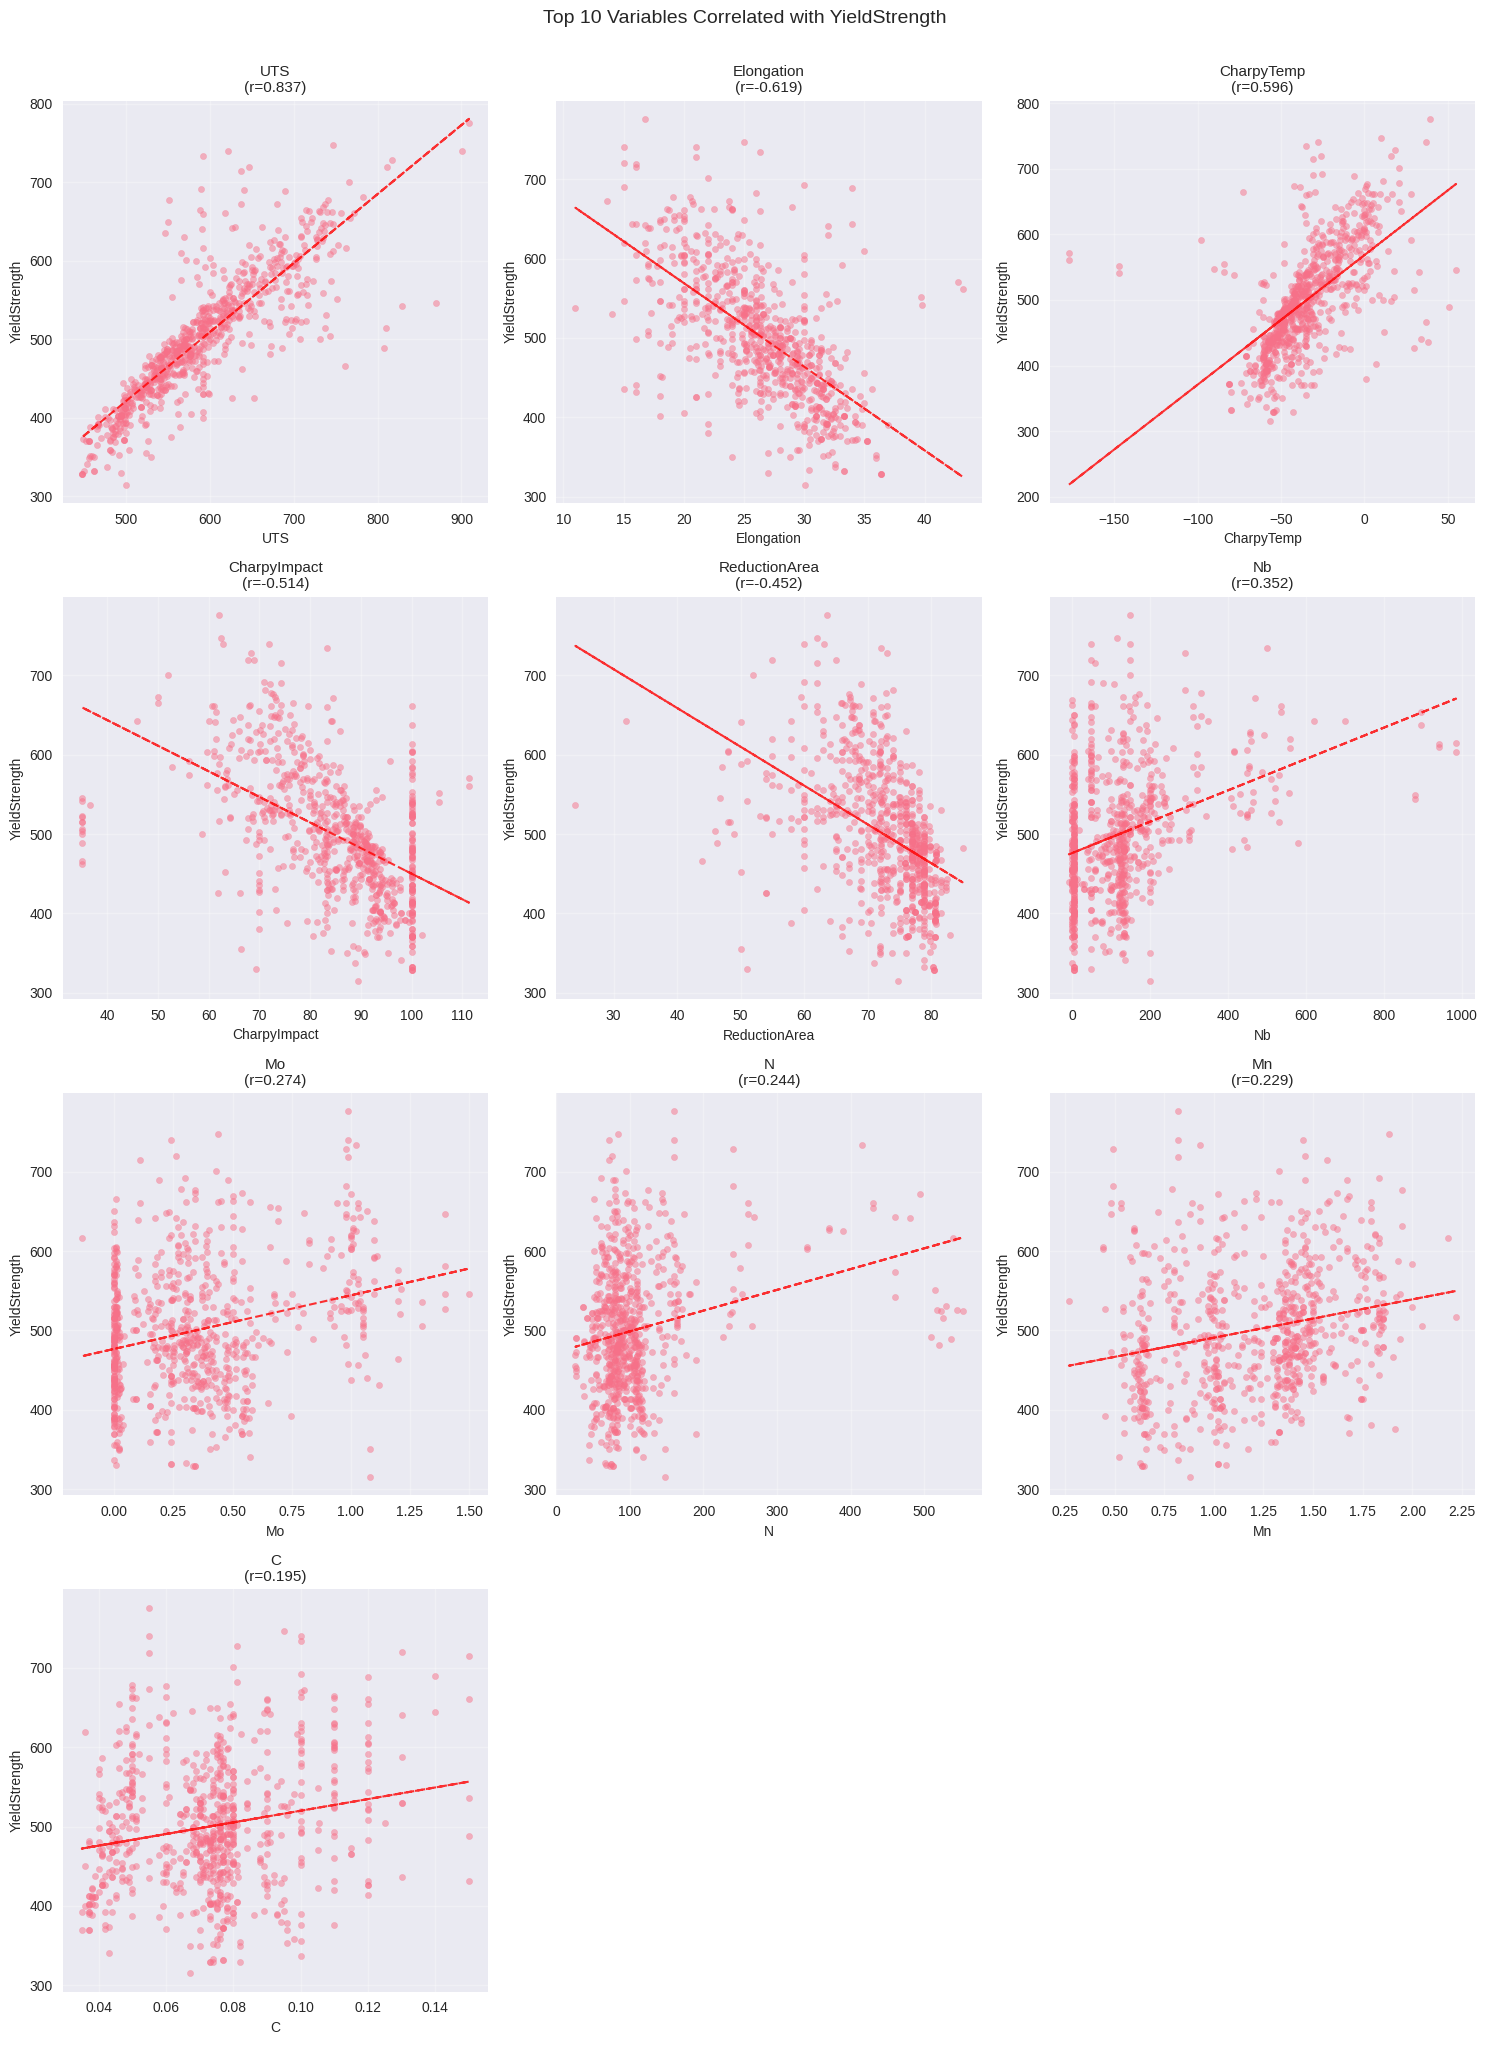

In [19]:
# Get top 10 most correlated variables (absolute value)
top_corr = pearson_df.head(10)

# Create scatter plots for top correlated variables
n_vars = len(top_corr)
n_cols = 3
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_vars > 1 else [axes]

for idx, (_, row) in enumerate(top_corr.iterrows()):
    var = row['Variable']
    corr = row['Correlation']
    
    data_subset = df_analysis[[var, TARGET]].dropna()
    axes[idx].scatter(data_subset[var], data_subset[TARGET], alpha=0.5, s=20)
    axes[idx].set_xlabel(var, fontsize=10)
    axes[idx].set_ylabel(TARGET, fontsize=10)
    axes[idx].set_title(f'{var}\n(r={corr:.3f})', fontsize=11)
    axes[idx].grid(alpha=0.3)
    
    # Add trend line
    if len(data_subset) > 1:
        z = np.polyfit(data_subset[var], data_subset[TARGET], 1)
        p = np.poly1d(z)
        axes[idx].plot(data_subset[var], p(data_subset[var]), "r--", alpha=0.8, linewidth=1.5)

# Hide extra subplots
for idx in range(n_vars, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Top 10 Variables Correlated with YieldStrength', fontsize=14, y=1.02)
plt.show()


## Correlation Analysis: Categorical Variables vs Target

### 1. ANOVA Test (Categorical vs Continuous Target)


In [20]:
# Perform ANOVA test for each categorical variable
anova_results = []

for cat_var in CATEGORICAL_VARS:
    # Remove missing values
    data_subset = df_analysis[[cat_var, TARGET]].dropna()
    
    if len(data_subset) > 0:
        # Get unique categories
        categories = data_subset[cat_var].unique()
        
        if len(categories) > 1:
            # Prepare data for ANOVA
            groups = [data_subset[data_subset[cat_var] == cat][TARGET].values 
                     for cat in categories if len(data_subset[data_subset[cat_var] == cat]) > 0]
            
            if len(groups) > 1 and all(len(g) > 0 for g in groups):
                # Perform ANOVA
                f_stat, p_value = stats.f_oneway(*groups)
                
                anova_results.append({
                    'Variable': cat_var,
                    'F-statistic': f_stat,
                    'P-value': p_value,
                    'Significant': p_value < 0.05,
                    'N_categories': len(categories),
                    'Categories': ', '.join([str(c) for c in categories])
                })

anova_df = pd.DataFrame(anova_results).sort_values('P-value')
print("ANOVA Test Results (Categorical Variables vs YieldStrength):")
print(anova_df.to_string(index=False))


ANOVA Test Results (Categorical Variables vs YieldStrength):
         Variable  F-statistic      P-value  Significant  N_categories                                       Categories
         WeldType     7.175975 3.479705e-09         True             9 MMA, SA, TSA, SAA, GTAA, GMAA, NGSAW, NGGMA, FCA
            AC_DC     4.352766 3.728394e-02         True             2                                           DC, AC
ElectrodePolarity     0.543422 5.809847e-01        False             3                                          +, 0, -


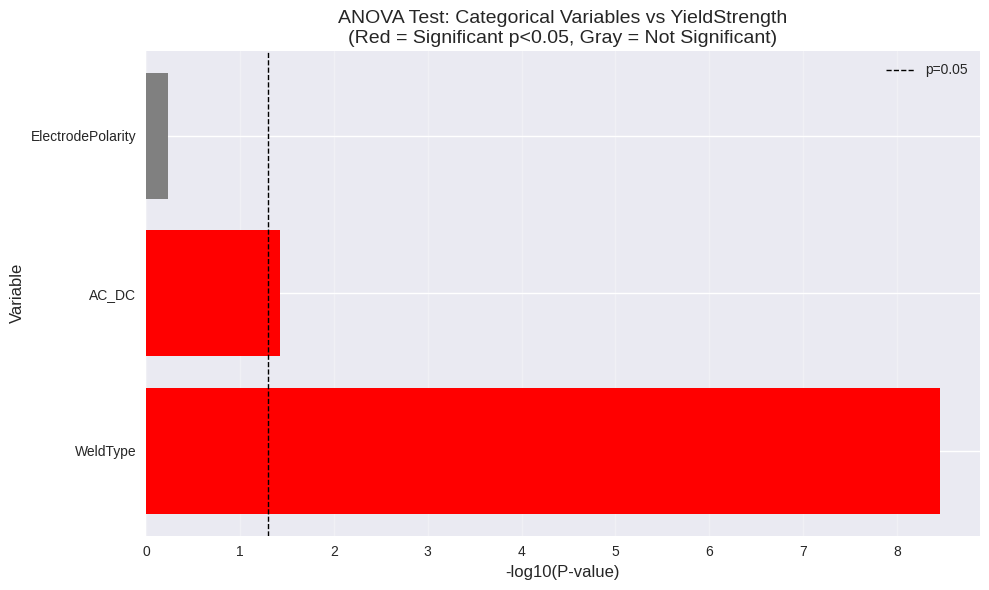

In [21]:
# Plot ANOVA results
if len(anova_df) > 0:
    plt.figure(figsize=(10, 6))
    colors = ['red' if p < 0.05 else 'gray' for p in anova_df['P-value']]
    plt.barh(range(len(anova_df)), -np.log10(anova_df['P-value']), color=colors)
    plt.yticks(range(len(anova_df)), anova_df['Variable'])
    plt.xlabel('-log10(P-value)', fontsize=12)
    plt.ylabel('Variable', fontsize=12)
    plt.title('ANOVA Test: Categorical Variables vs YieldStrength\n(Red = Significant p<0.05, Gray = Not Significant)', fontsize=14)
    plt.axvline(x=-np.log10(0.05), color='black', linestyle='--', linewidth=1, label='p=0.05')
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()


### 2. Boxplots: Categorical Variables vs Target


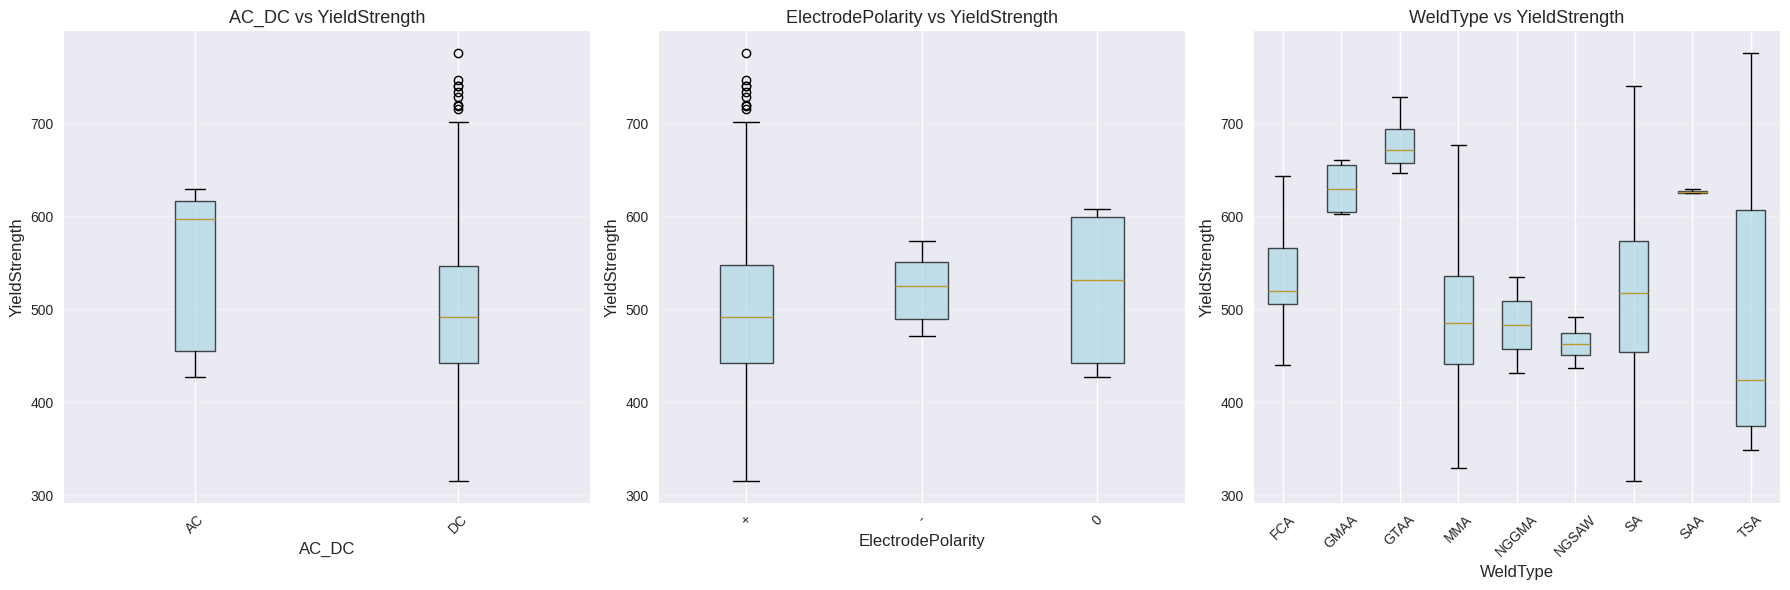

In [22]:
# Create boxplots for each categorical variable
n_vars = len(CATEGORICAL_VARS)
fig, axes = plt.subplots(1, n_vars, figsize=(6*n_vars, 6))

if n_vars == 1:
    axes = [axes]

for idx, cat_var in enumerate(CATEGORICAL_VARS):
    data_subset = df_analysis[[cat_var, TARGET]].dropna()
    
    # Create boxplot
    categories = sorted(data_subset[cat_var].unique())
    data_to_plot = [data_subset[data_subset[cat_var] == cat][TARGET].values for cat in categories]
    
    bp = axes[idx].boxplot(data_to_plot, labels=categories, patch_artist=True)
    
    # Color boxes
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    
    axes[idx].set_xlabel(cat_var, fontsize=12)
    axes[idx].set_ylabel(TARGET, fontsize=12)
    axes[idx].set_title(f'{cat_var} vs {TARGET}', fontsize=13)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### 3. Violin Plots: Categorical Variables vs Target


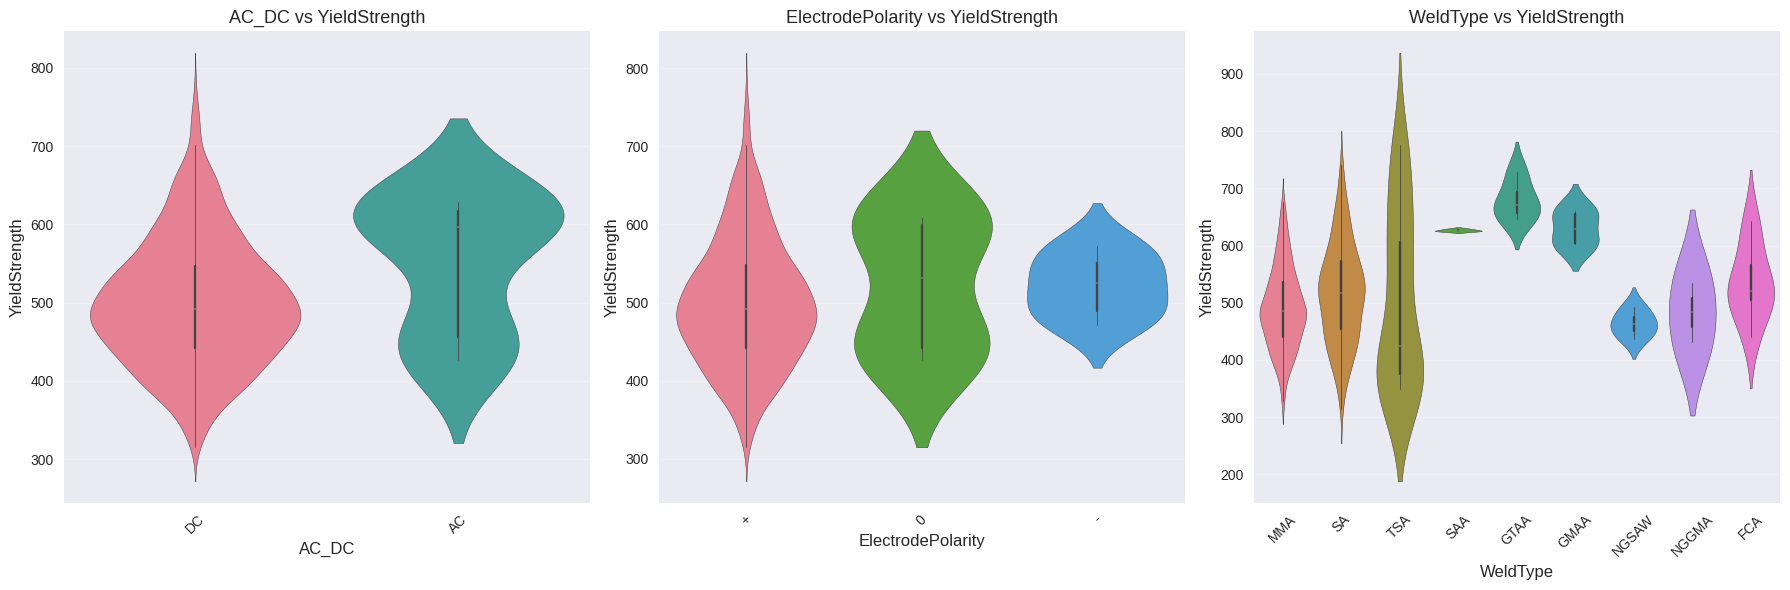

In [23]:
# Create violin plots for each categorical variable
n_vars = len(CATEGORICAL_VARS)
fig, axes = plt.subplots(1, n_vars, figsize=(6*n_vars, 6))

if n_vars == 1:
    axes = [axes]

for idx, cat_var in enumerate(CATEGORICAL_VARS):
    data_subset = df_analysis[[cat_var, TARGET]].dropna()
    
    # Create violin plot
    sns.violinplot(data=data_subset, x=cat_var, y=TARGET, ax=axes[idx], palette='husl')
    axes[idx].set_xlabel(cat_var, fontsize=12)
    axes[idx].set_ylabel(TARGET, fontsize=12)
    axes[idx].set_title(f'{cat_var} vs {TARGET}', fontsize=13)
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


## Correlation Matrix: All Variables (Numerical + Encoded Categorical)

Encode categorical variables and create a comprehensive correlation matrix.


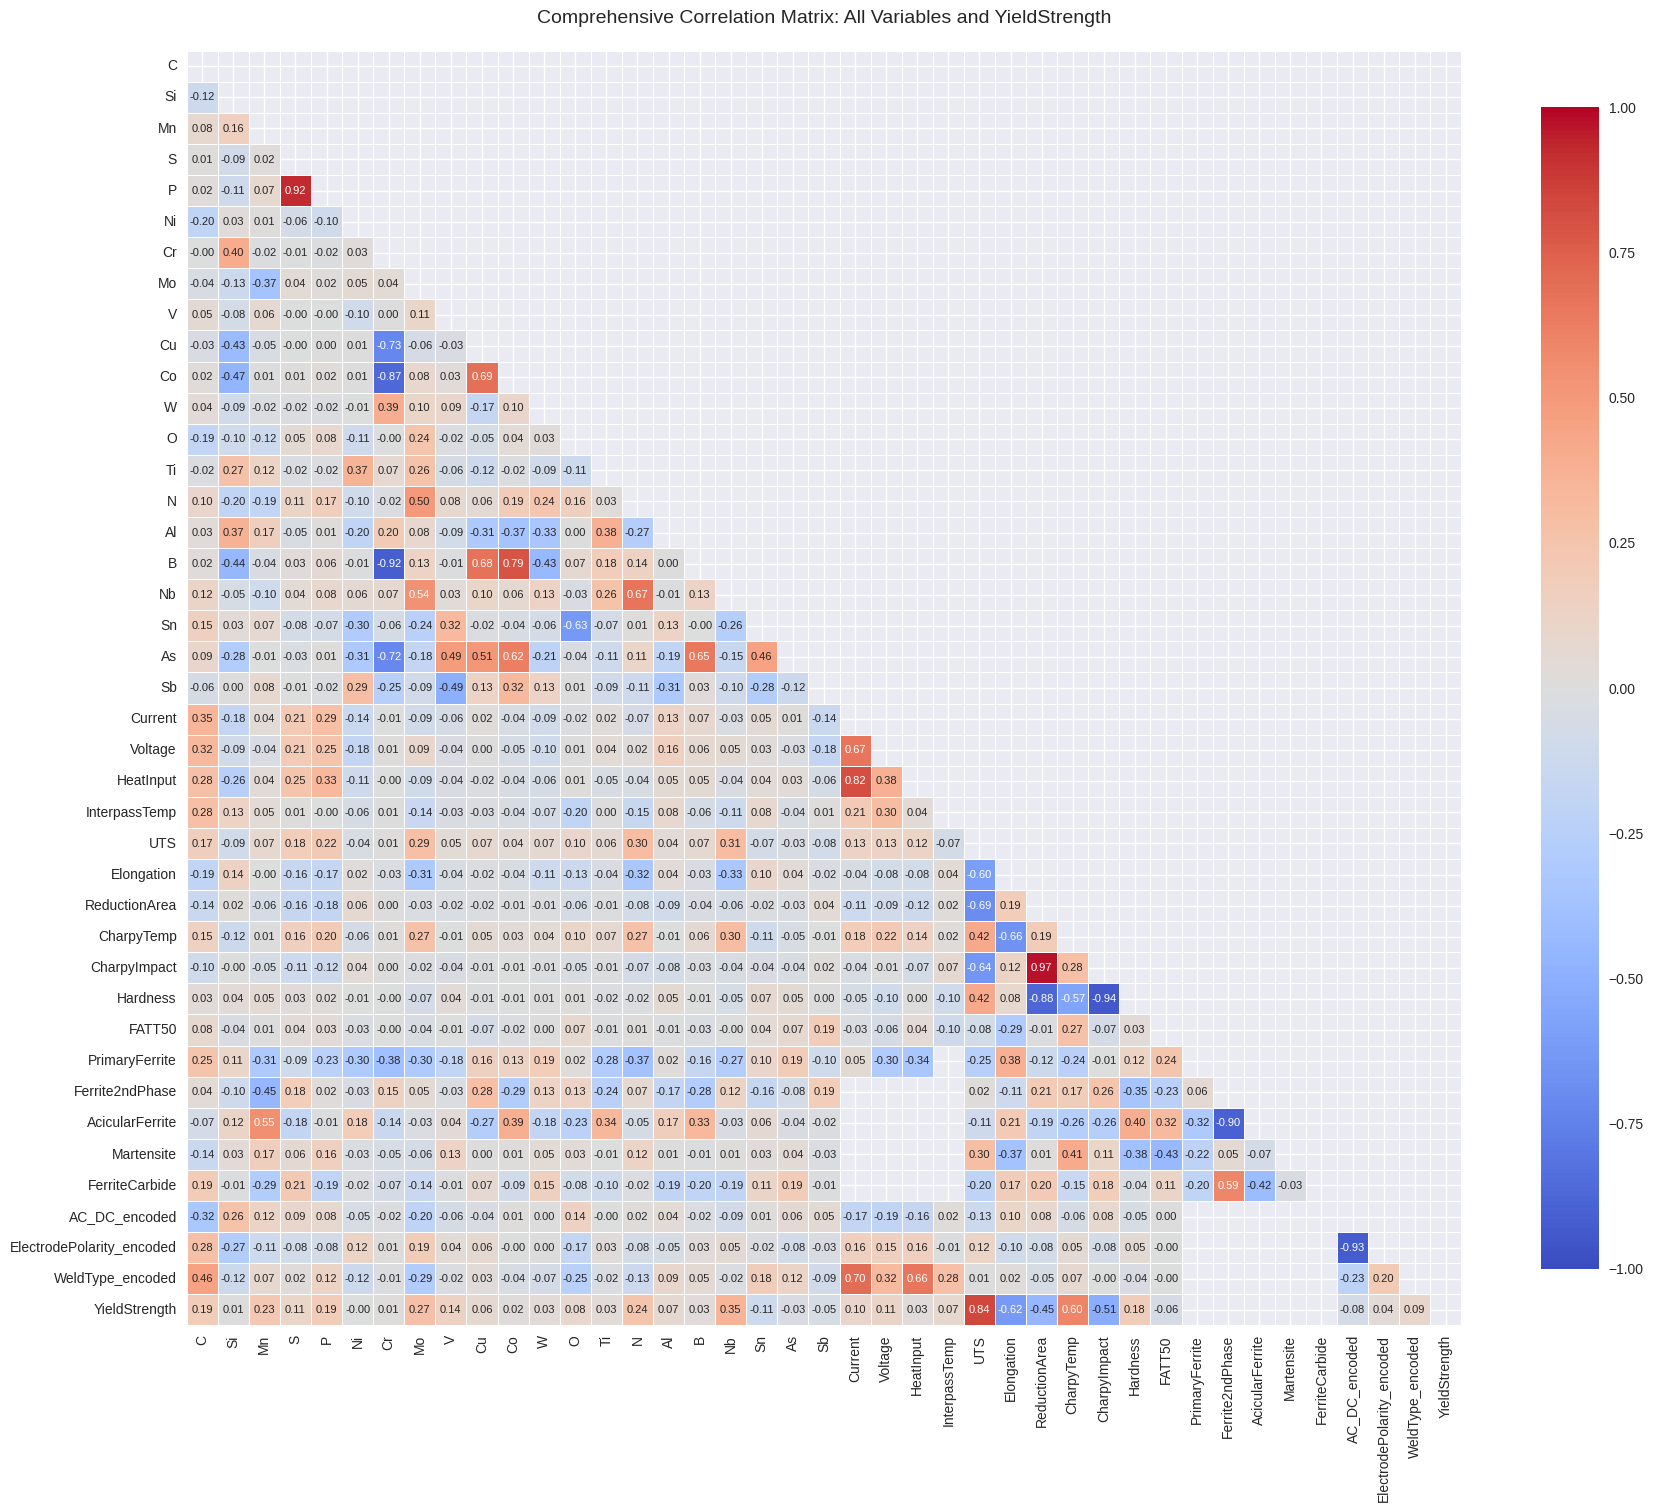

In [24]:
# Encode categorical variables for correlation analysis
df_encoded = df_analysis.copy()

# Label encode categorical variables
le_dict = {}
for cat_var in CATEGORICAL_VARS:
    le = LabelEncoder()
    df_encoded[cat_var + '_encoded'] = le.fit_transform(df_encoded[cat_var].astype(str))
    le_dict[cat_var] = le

# Create comprehensive correlation matrix
all_vars = NUMERICAL_VARS + [cat_var + '_encoded' for cat_var in CATEGORICAL_VARS] + [TARGET]
corr_all = df_encoded[all_vars].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(18, 16))
mask = np.triu(np.ones_like(corr_all, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_all, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 8})
plt.title('Comprehensive Correlation Matrix: All Variables and YieldStrength', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


## Summary: Top Correlations with YieldStrength


In [25]:
# Create summary of top correlations
print("="*80)
print("SUMMARY: TOP CORRELATIONS WITH YieldStrength")
print("="*80)

print("\n📊 TOP 10 NUMERICAL VARIABLES (Pearson Correlation):")
print("-" * 80)
top_10_pearson = pearson_df.head(10)
for idx, row in top_10_pearson.iterrows():
    sig = "✓" if row['Significant'] else "✗"
    print(f"{sig} {row['Variable']:25s} | r = {row['Correlation']:7.4f} | p = {row['P-value']:.4e}")

print("\n📊 TOP 10 NUMERICAL VARIABLES (Spearman Correlation):")
print("-" * 80)
top_10_spearman = spearman_df.head(10)
for idx, row in top_10_spearman.iterrows():
    sig = "✓" if row['Significant'] else "✗"
    print(f"{sig} {row['Variable']:25s} | ρ = {row['Correlation']:7.4f} | p = {row['P-value']:.4e}")

if len(anova_df) > 0:
    print("\n📊 CATEGORICAL VARIABLES (ANOVA):")
    print("-" * 80)
    for idx, row in anova_df.iterrows():
        sig = "✓" if row['Significant'] else "✗"
        print(f"{sig} {row['Variable']:25s} | F = {row['F-statistic']:7.4f} | p = {row['P-value']:.4e}")

print("\n" + "="*80)


SUMMARY: TOP CORRELATIONS WITH YieldStrength

📊 TOP 10 NUMERICAL VARIABLES (Pearson Correlation):
--------------------------------------------------------------------------------
✓ UTS                       | r =  0.8367 | p = 1.3644e-199
✓ Elongation                | r = -0.6187 | p = 3.5179e-81
✓ CharpyTemp                | r =  0.5964 | p = 4.2217e-74
✓ CharpyImpact              | r = -0.5139 | p = 3.0645e-52
✓ ReductionArea             | r = -0.4522 | p = 2.0370e-39
✓ Nb                        | r =  0.3520 | p = 1.6908e-23
✓ Mo                        | r =  0.2738 | p = 1.7629e-14
✓ N                         | r =  0.2442 | p = 9.7805e-12
✓ Mn                        | r =  0.2289 | p = 1.8501e-10
✓ C                         | r =  0.1950 | p = 6.3761e-08

📊 TOP 10 NUMERICAL VARIABLES (Spearman Correlation):
--------------------------------------------------------------------------------
✓ UTS                       | ρ =  0.8859 | p = 3.9520e-254
✓ CharpyTemp                | ρ =  

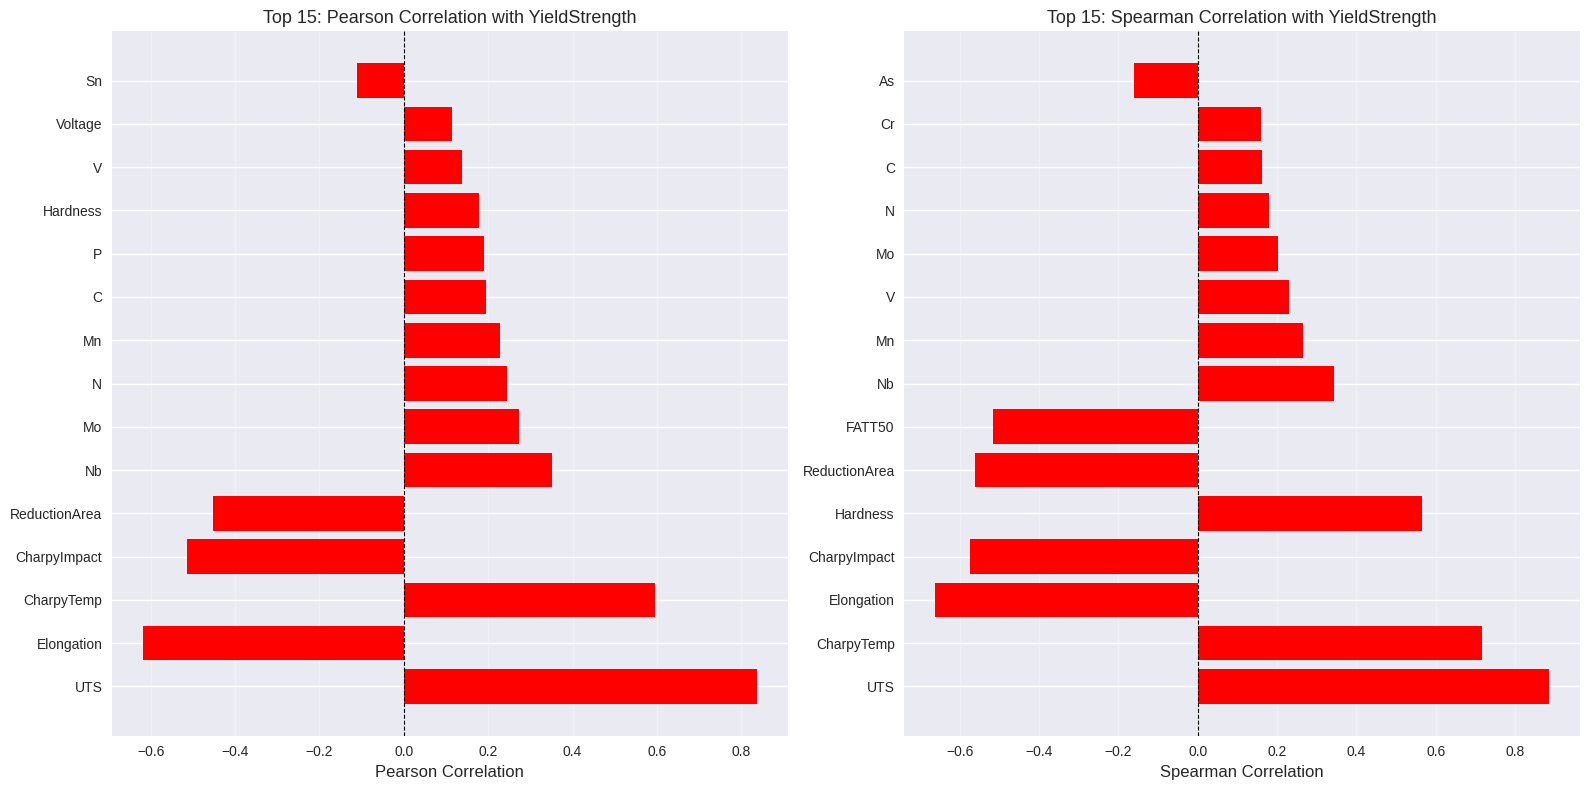

In [26]:
# Create a combined summary plot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Top Pearson correlations
top_15_pearson = pearson_df.head(15)
colors1 = ['red' if p < 0.05 else 'gray' for p in top_15_pearson['P-value']]
axes[0].barh(range(len(top_15_pearson)), top_15_pearson['Correlation'], color=colors1)
axes[0].set_yticks(range(len(top_15_pearson)))
axes[0].set_yticklabels(top_15_pearson['Variable'])
axes[0].set_xlabel('Pearson Correlation', fontsize=12)
axes[0].set_title('Top 15: Pearson Correlation with YieldStrength', fontsize=13)
axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Top Spearman correlations
top_15_spearman = spearman_df.head(15)
colors2 = ['red' if p < 0.05 else 'gray' for p in top_15_spearman['P-value']]
axes[1].barh(range(len(top_15_spearman)), top_15_spearman['Correlation'], color=colors2)
axes[1].set_yticks(range(len(top_15_spearman)))
axes[1].set_yticklabels(top_15_spearman['Variable'])
axes[1].set_xlabel('Spearman Correlation', fontsize=12)
axes[1].set_title('Top 15: Spearman Correlation with YieldStrength', fontsize=13)
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
## Define Column Groups for Inter-Group Correlation Analysis

# Define groups based on what exists in the dataset
CHEM_COLS = [
    'C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co',
    'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb'
]

MECH_COLS = [
    'UTS', 'Elongation', 'ReductionArea',
    'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
]

PROC_NUM_COLS = [
    'Current', 'Voltage', 'HeatInput', 'InterpassTemp'
]

PROC_CAT_COLS = [
    'AC_DC', 'ElectrodePolarity', 'WeldType'
]

MICRO_COLS = [
    'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 
    'Martensite', 'FerriteCarbide'
]

# Combine all groups (excluding categorical for numerical correlation analysis)
ALL_GROUPS = {
    'Chemical': CHEM_COLS,
    'Mechanical': MECH_COLS,
    'Process_Numerical': PROC_NUM_COLS,
    'Microstructure': MICRO_COLS
}

# Filter groups to only include columns that exist in the dataset
for group_name in ALL_GROUPS:
    ALL_GROUPS[group_name] = [col for col in ALL_GROUPS[group_name] if col in df.columns]

# Get all columns assigned to groups (numerical only for correlation)
all_assigned_cols = []
for group_cols in ALL_GROUPS.values():
    all_assigned_cols.extend(group_cols)

# Identify missing columns (columns not in any group, excluding target and excluded columns)
all_numeric_feature_cols = [col for col in NUMERICAL_VARS if col not in [TARGET]]
missing_cols = [col for col in all_numeric_feature_cols if col not in all_assigned_cols]

print("="*80)
print("COLUMN GROUPS DEFINITION")
print("="*80)
for group_name, group_cols in ALL_GROUPS.items():
    print(f"\n{group_name} ({len(group_cols)} columns):")
    print(f"  {group_cols}")

print(f"\n{'='*80}")
print(f"CATEGORICAL PROCESS VARIABLES ({len(PROC_CAT_COLS)} columns):")
print(f"  {PROC_CAT_COLS}")

print(f"\n{'='*80}")
print(f"COLUMNS NOT ASSIGNED TO ANY GROUP (excluding target):")
if len(missing_cols) > 0:
    print(f"  Found {len(missing_cols)} missing columns:")
    for col in missing_cols:
        print(f"    - {col}")
else:
    print("  ✓ All numerical columns are assigned to a group!")

print(f"\n{'='*80}")
print(f"SUMMARY:")
print(f"  Total numerical feature columns: {len(all_numeric_feature_cols)}")
print(f"  Columns assigned to groups: {len(all_assigned_cols)}")
print(f"  Missing columns: {len(missing_cols)}")
print("="*80)


COLUMN GROUPS DEFINITION

Chemical (21 columns):
  ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb']

Mechanical (7 columns):
  ['UTS', 'Elongation', 'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50']

Process_Numerical (4 columns):
  ['Current', 'Voltage', 'HeatInput', 'InterpassTemp']

Microstructure (5 columns):
  ['PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite', 'FerriteCarbide']

CATEGORICAL PROCESS VARIABLES (3 columns):
  ['AC_DC', 'ElectrodePolarity', 'WeldType']

COLUMNS NOT ASSIGNED TO ANY GROUP (excluding target):
  ✓ All numerical columns are assigned to a group!

SUMMARY:
  Total numerical feature columns: 37
  Columns assigned to groups: 37
  Missing columns: 0


## Inter-Group Correlation Analysis

Analyze linear relationships (Pearson correlation) between different groups of columns.


In [29]:
# Prepare data for correlation analysis (only rows where target exists)
df_corr = df_analysis.copy()

# Calculate correlation matrix for all numerical variables
all_num_cols = []
for group_cols in ALL_GROUPS.values():
    # Only include columns that have data
    existing_cols = [col for col in group_cols if col in df_corr.columns]
    all_num_cols.extend(existing_cols)

# Add missing columns if any
if len(missing_cols) > 0:
    all_num_cols.extend([col for col in missing_cols if col in df_corr.columns])

# Remove duplicates and calculate correlation
all_num_cols = list(set(all_num_cols))
corr_matrix_full = df_corr[all_num_cols].corr(method='pearson')

print(f"Calculating correlations for {len(all_num_cols)} numerical columns...")
print(f"Data shape: {df_corr[all_num_cols].shape}")


Calculating correlations for 37 numerical columns...
Data shape: (1652, 37)


### 1. Average Inter-Group Correlation Heatmap

Calculate average correlation between groups (mean of all pairwise correlations between groups).


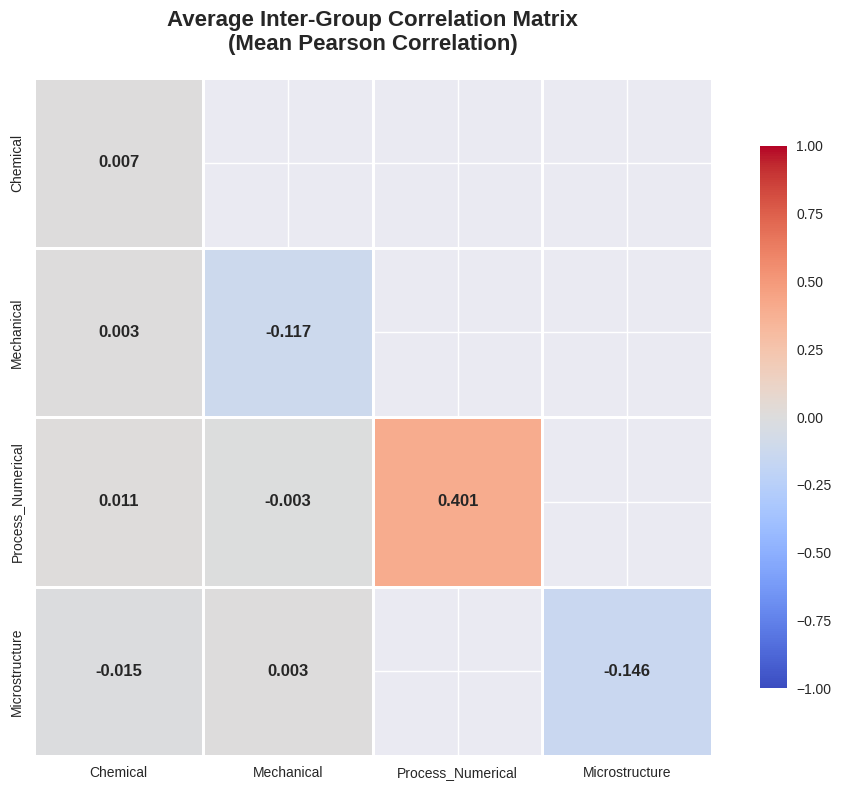


Average Inter-Group Correlations:
                   Chemical  Mechanical  Process_Numerical  Microstructure
Chemical              0.007       0.003              0.011          -0.015
Mechanical            0.003      -0.117             -0.003           0.003
Process_Numerical     0.011      -0.003              0.401             NaN
Microstructure       -0.015       0.003                NaN          -0.146


In [30]:
# Calculate average inter-group correlations
group_names = list(ALL_GROUPS.keys())
if len(missing_cols) > 0:
    group_names.append('Unassigned')

inter_group_corr = np.zeros((len(group_names), len(group_names)))

for i, group1 in enumerate(ALL_GROUPS.keys()):
    cols1 = [col for col in ALL_GROUPS[group1] if col in corr_matrix_full.columns]
    if len(cols1) == 0:
        continue
    
    for j, group2 in enumerate(ALL_GROUPS.keys()):
        cols2 = [col for col in ALL_GROUPS[group2] if col in corr_matrix_full.columns]
        if len(cols2) == 0:
            continue
        
        # Calculate average correlation between groups
        if i == j:
            # Within-group correlation (exclude diagonal)
            group_corr = corr_matrix_full.loc[cols1, cols2].values
            # Get upper triangle (excluding diagonal)
            mask = np.triu(np.ones_like(group_corr, dtype=bool), k=1)
            if mask.sum() > 0:
                inter_group_corr[i, j] = group_corr[mask].mean()
        else:
            # Between-group correlation
            inter_group_corr[i, j] = corr_matrix_full.loc[cols1, cols2].values.mean()
    
    # Calculate correlation with unassigned columns if they exist
    if len(missing_cols) > 0:
        unassigned_cols = [col for col in missing_cols if col in corr_matrix_full.columns]
        if len(unassigned_cols) > 0:
            inter_group_corr[i, len(group_names)-1] = corr_matrix_full.loc[cols1, unassigned_cols].values.mean()
            inter_group_corr[len(group_names)-1, i] = inter_group_corr[i, len(group_names)-1]

# Handle unassigned group self-correlation
if len(missing_cols) > 0:
    unassigned_cols = [col for col in missing_cols if col in corr_matrix_full.columns]
    if len(unassigned_cols) > 0:
        unassigned_corr = corr_matrix_full.loc[unassigned_cols, unassigned_cols].values
        mask = np.triu(np.ones_like(unassigned_corr, dtype=bool), k=1)
        if mask.sum() > 0:
            inter_group_corr[len(group_names)-1, len(group_names)-1] = unassigned_corr[mask].mean()

# Create DataFrame for better visualization
inter_group_df = pd.DataFrame(inter_group_corr, index=group_names, columns=group_names)

# Plot heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(inter_group_df, dtype=bool), k=1)
sns.heatmap(inter_group_df, mask=mask, annot=True, fmt='.3f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'size': 12, 'weight': 'bold'})
plt.title('Average Inter-Group Correlation Matrix\n(Mean Pearson Correlation)', 
          fontsize=16, pad=20, weight='bold')
plt.tight_layout()
plt.show()

print("\nAverage Inter-Group Correlations:")
print(inter_group_df.round(3))


## Intra-Group Correlation Analysis

Analyze linear relationships (Pearson correlation) within each group of columns.


INTRA-GROUP CORRELATION HEATMAPS


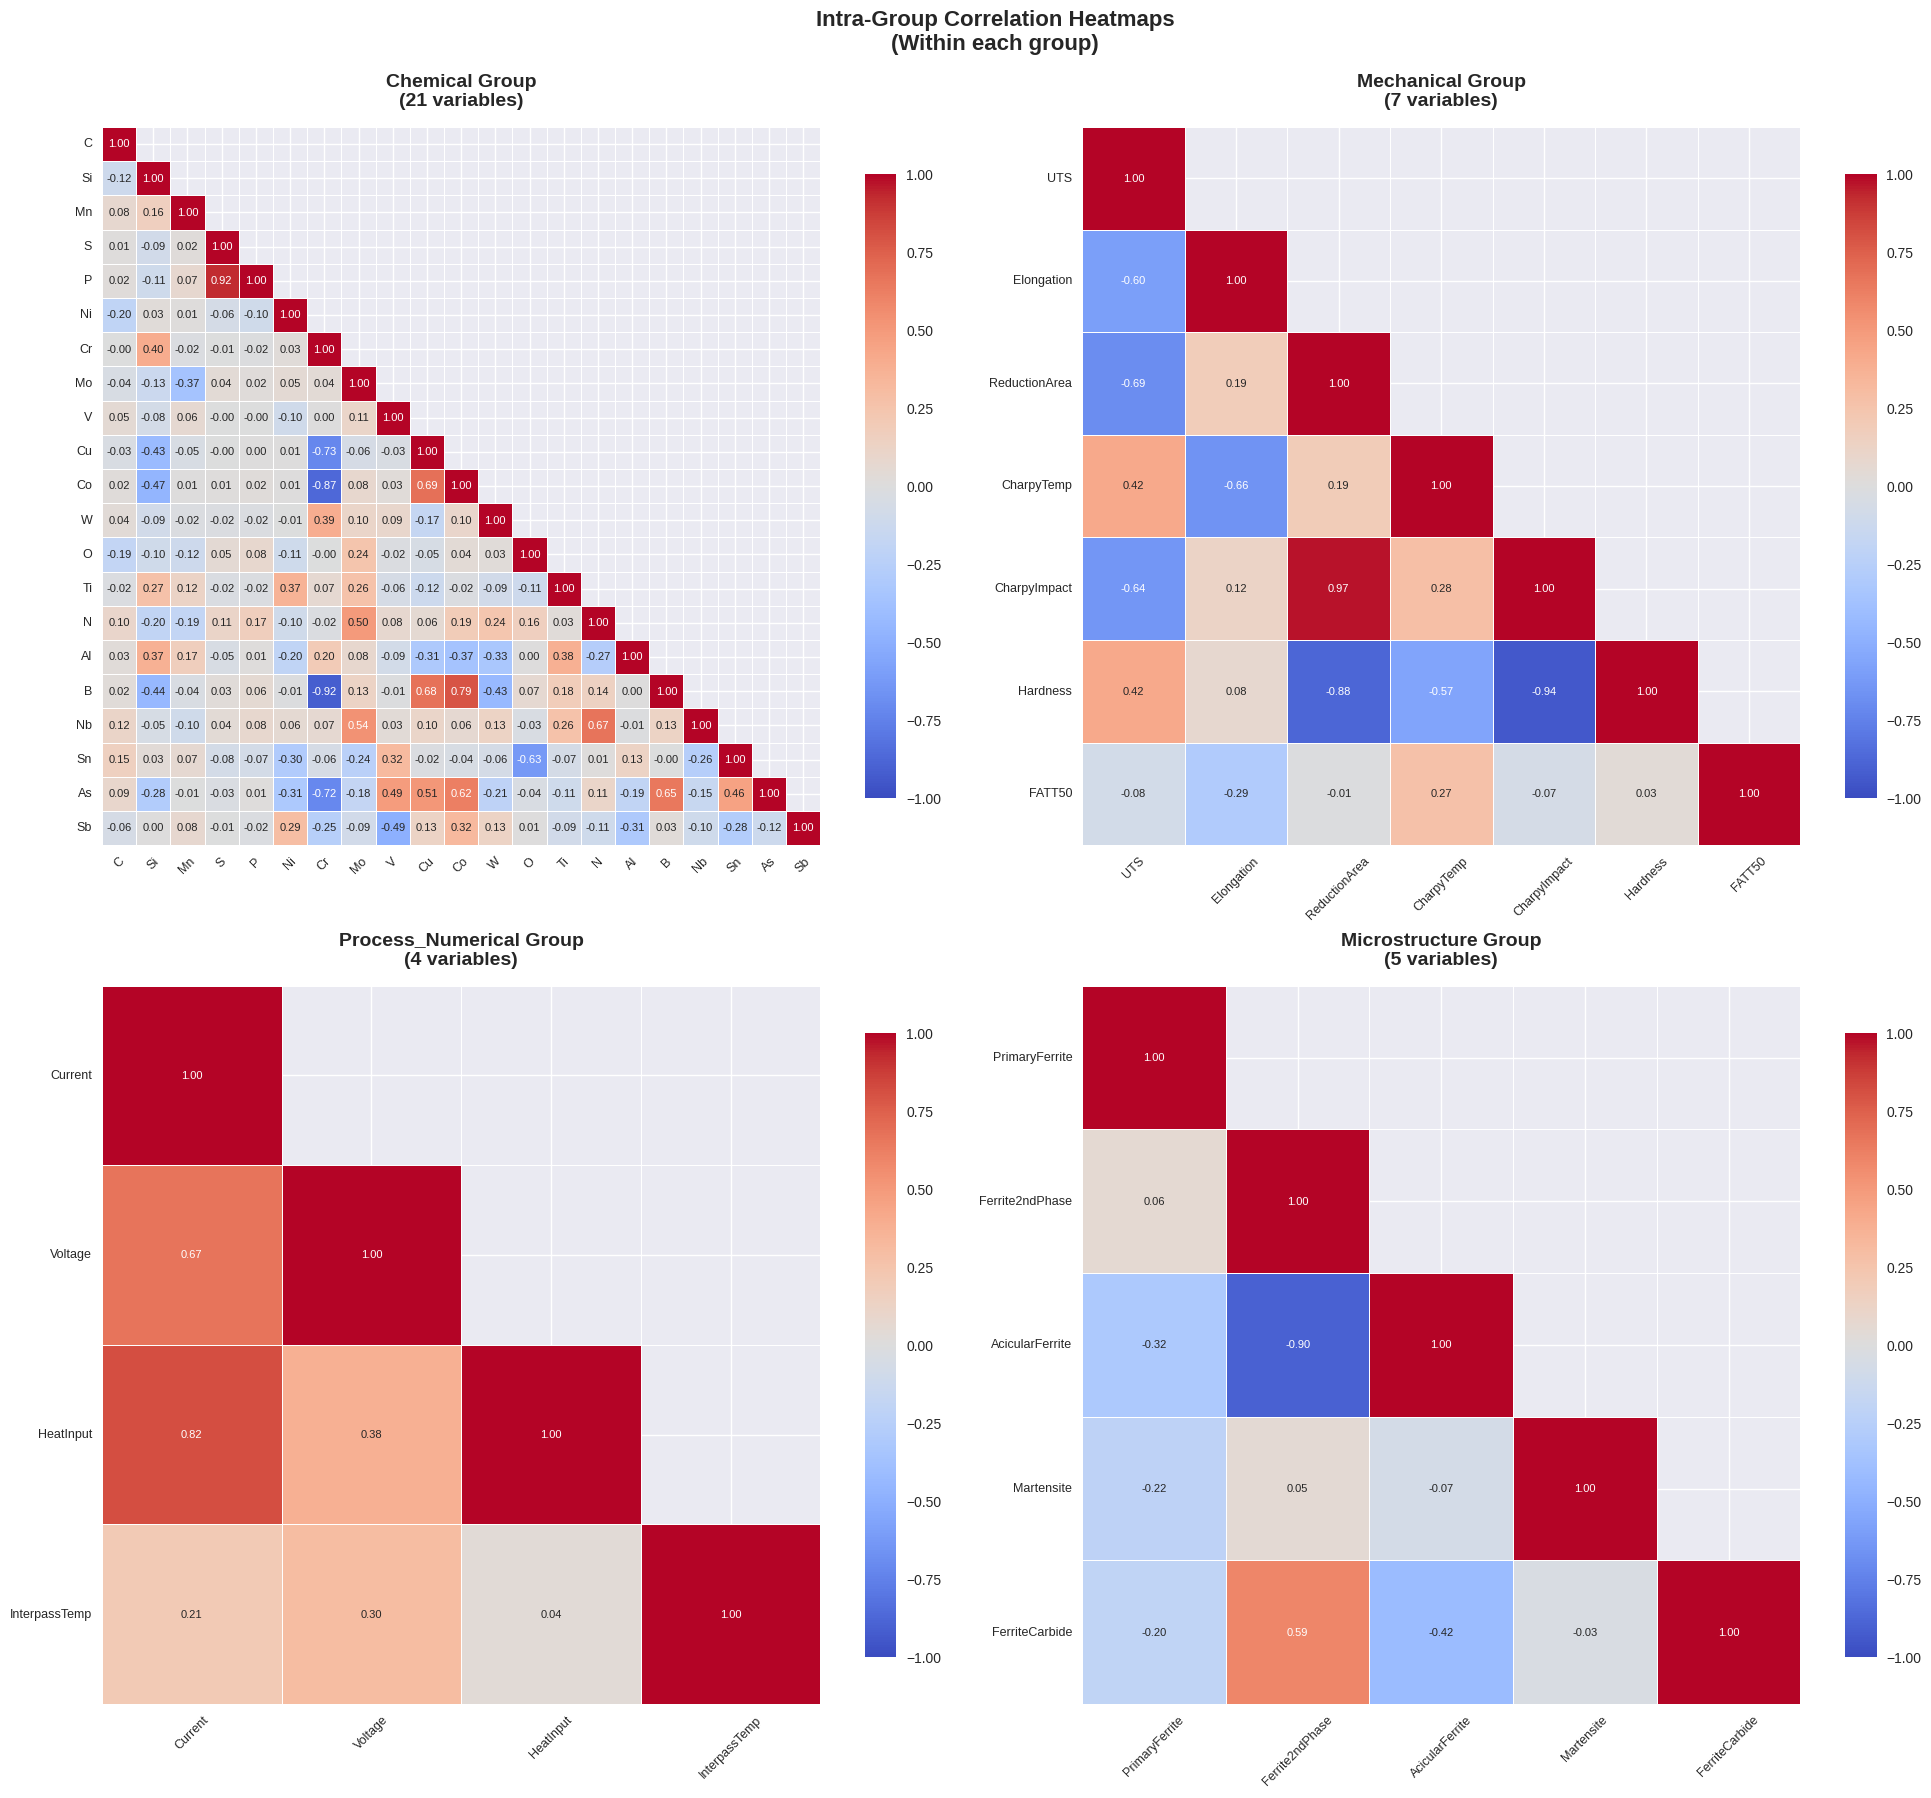


Created 4 intra-group correlation heatmaps


In [36]:
# Create intra-group correlation heatmaps for each group
print("="*80)
print("INTRA-GROUP CORRELATION HEATMAPS")
print("="*80)

# Calculate number of groups (including unassigned if exists)
n_groups = len(ALL_GROUPS)
if len(missing_cols) > 0:
    unassigned_cols = [col for col in missing_cols if col in corr_matrix_full.columns]
    if len(unassigned_cols) > 0:
        n_groups += 1

# Create subplots for all groups
fig, axes = plt.subplots(2, 2, figsize=(20, 18))
axes = axes.flatten()

group_idx = 0
for group_name, group_cols in ALL_GROUPS.items():
    # Filter to only existing columns
    existing_cols = [col for col in group_cols if col in corr_matrix_full.columns]
    
    if len(existing_cols) > 0:
        # Get correlation matrix for this group
        group_corr = corr_matrix_full.loc[existing_cols, existing_cols]
        
        # Create heatmap
        mask = np.triu(np.ones_like(group_corr, dtype=bool), k=1)  # Mask upper triangle
        sns.heatmap(group_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                    center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                    vmin=-1, vmax=1, ax=axes[group_idx], annot_kws={'size': 8})
        
        axes[group_idx].set_title(f'{group_name} Group\n({len(existing_cols)} variables)', 
                                  fontsize=14, weight='bold', pad=15)
        axes[group_idx].tick_params(axis='x', rotation=45, labelsize=9)
        axes[group_idx].tick_params(axis='y', rotation=0, labelsize=9)
        
        group_idx += 1

# Hide unused subplots
for idx in range(group_idx, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Intra-Group Correlation Heatmaps\n(Within each group)', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\nCreated {group_idx} intra-group correlation heatmaps")


### Detailed Intra-Group Correlation Heatmaps

Individual detailed heatmaps for each group with larger size for better readability.


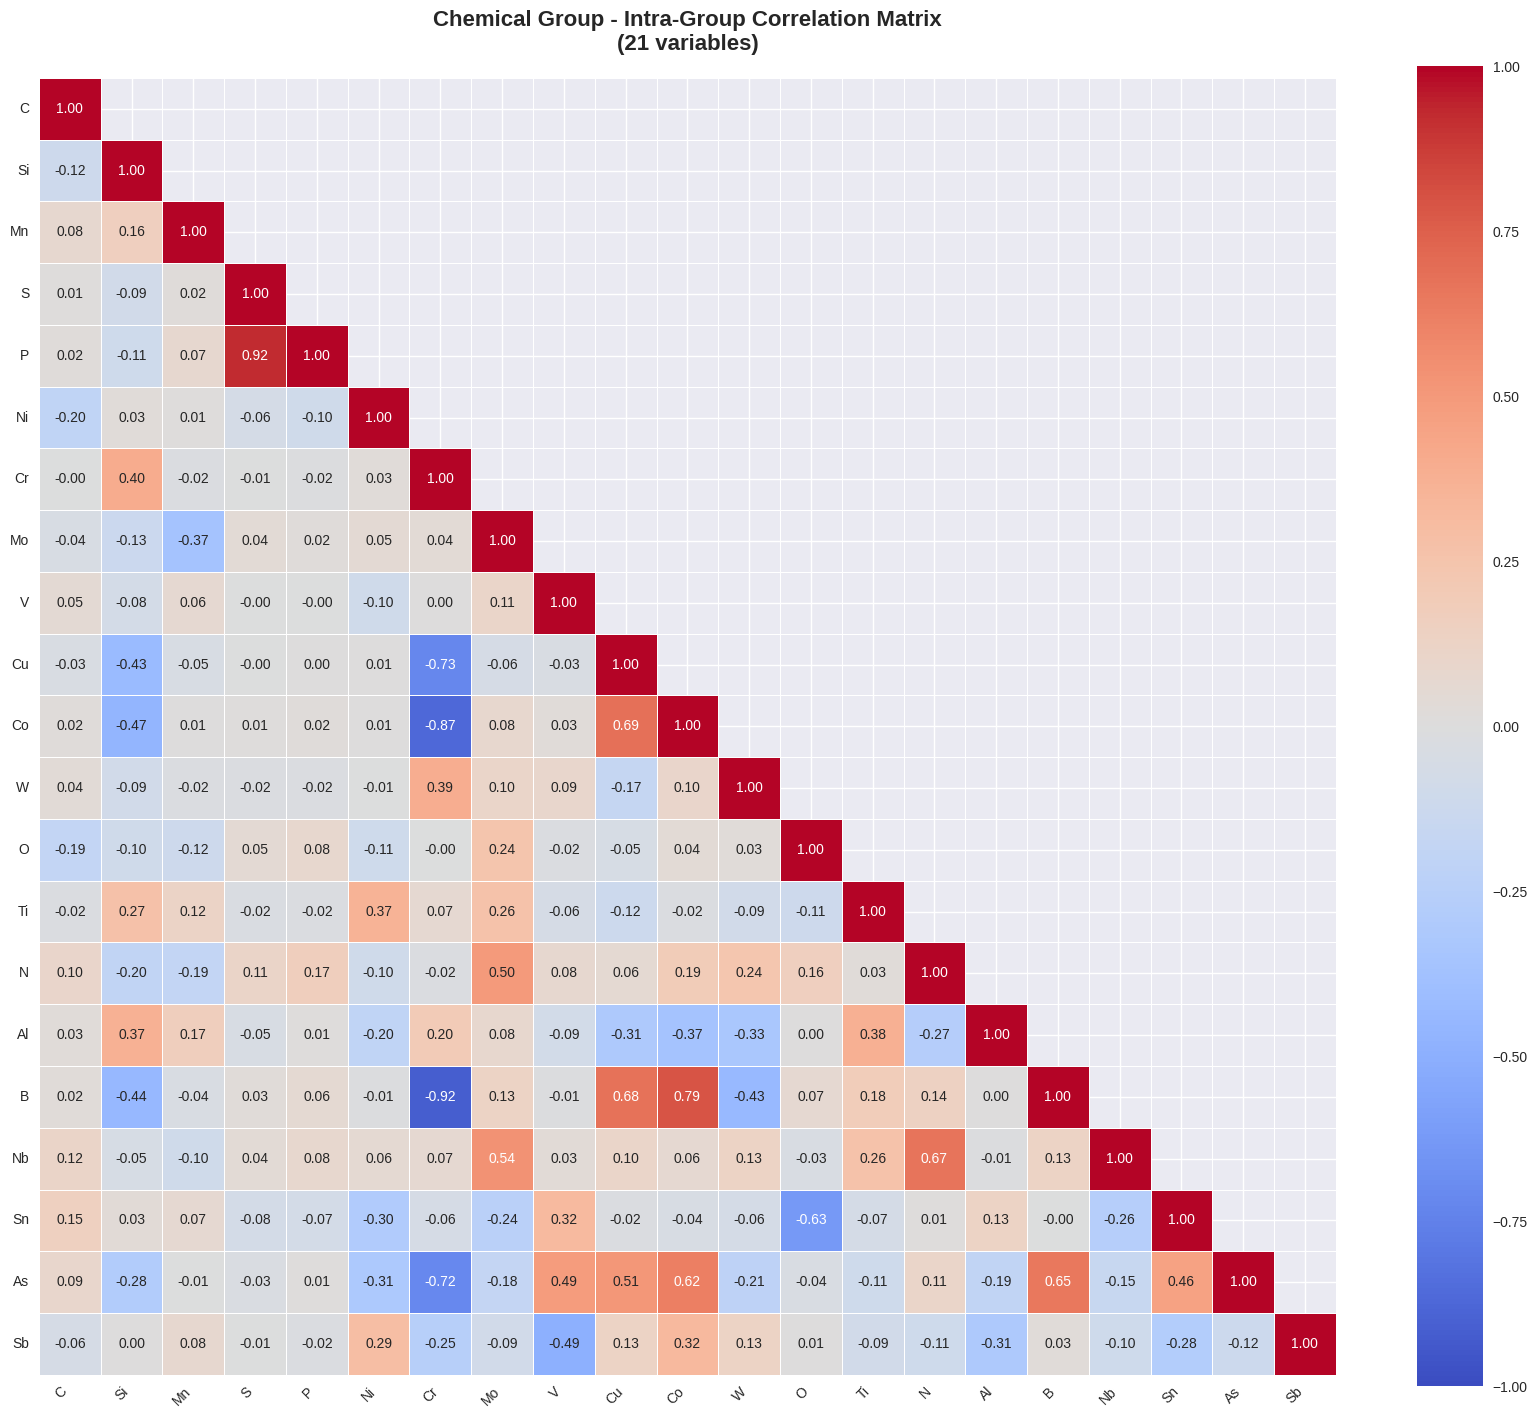


Chemical Group Statistics:
  Number of variables: 21
  Number of correlations: 210
  Mean correlation: 0.007
  Std correlation: 0.246
  Min correlation: -0.917
  Max correlation: 0.924
  Strong correlations (|r| >= 0.5): 14 (6.7%)
  Strong correlations (|r| >= 0.7): 6 (2.9%)
--------------------------------------------------------------------------------


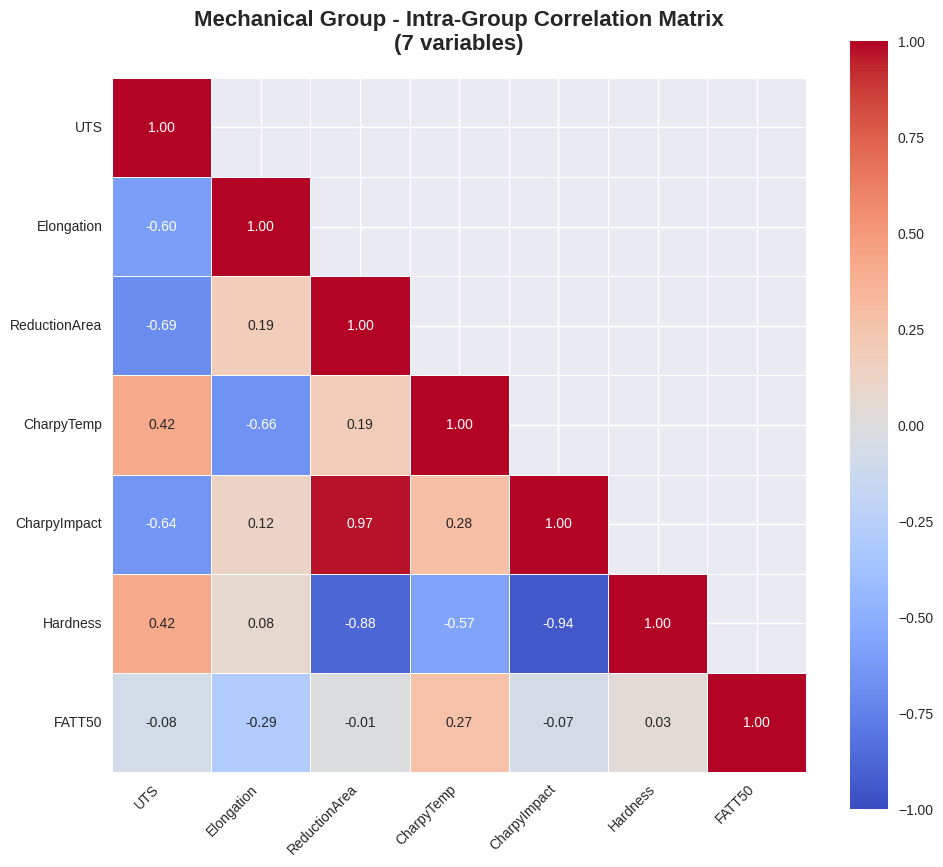


Mechanical Group Statistics:
  Number of variables: 7
  Number of correlations: 21
  Mean correlation: -0.117
  Std correlation: 0.489
  Min correlation: -0.941
  Max correlation: 0.975
  Strong correlations (|r| >= 0.5): 8 (38.1%)
  Strong correlations (|r| >= 0.7): 3 (14.3%)
--------------------------------------------------------------------------------


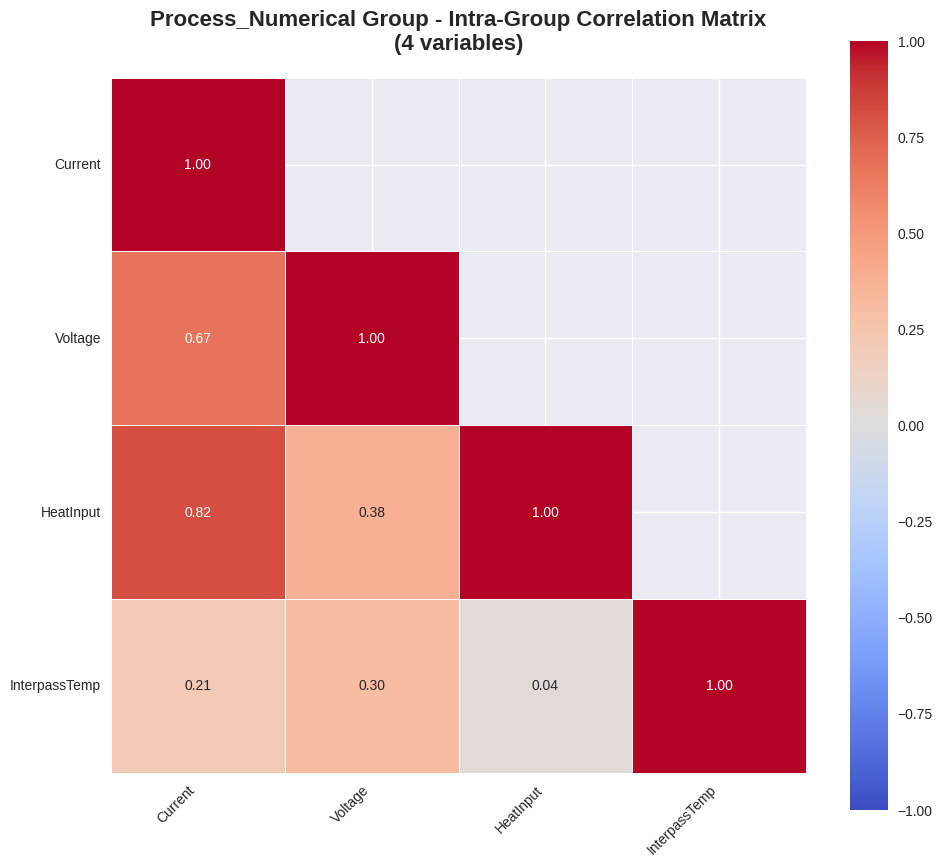


Process_Numerical Group Statistics:
  Number of variables: 4
  Number of correlations: 6
  Mean correlation: 0.401
  Std correlation: 0.267
  Min correlation: 0.036
  Max correlation: 0.818
  Strong correlations (|r| >= 0.5): 2 (33.3%)
  Strong correlations (|r| >= 0.7): 1 (16.7%)
--------------------------------------------------------------------------------


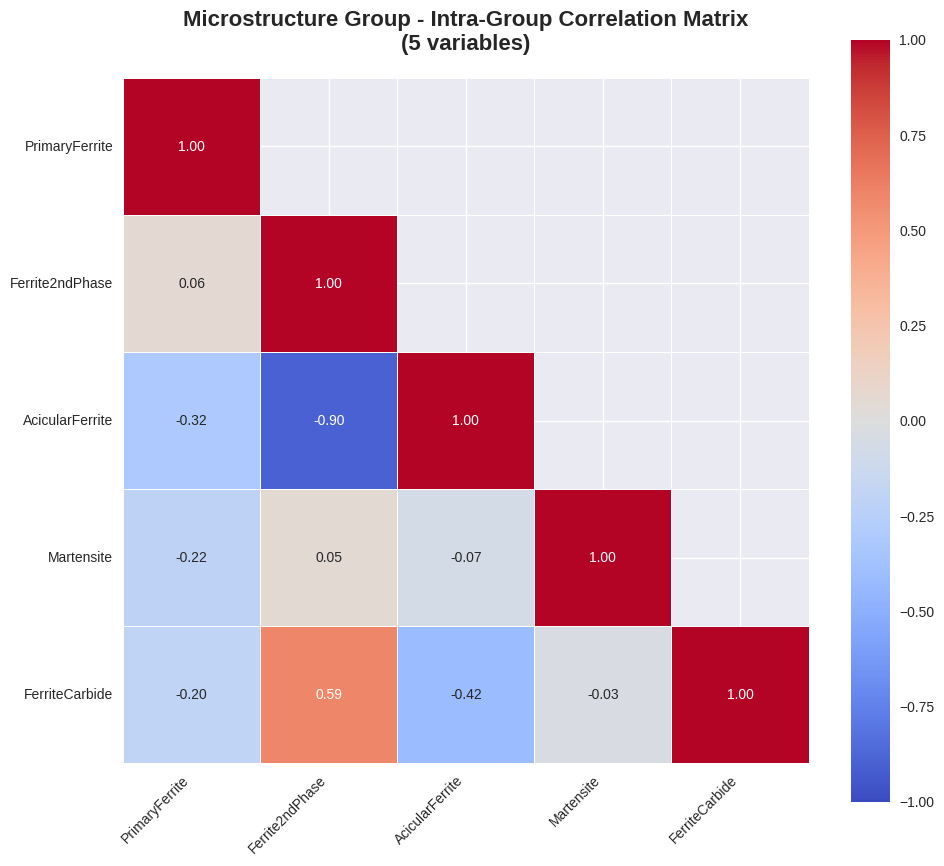


Microstructure Group Statistics:
  Number of variables: 5
  Number of correlations: 10
  Mean correlation: -0.146
  Std correlation: 0.364
  Min correlation: -0.902
  Max correlation: 0.591
  Strong correlations (|r| >= 0.5): 2 (20.0%)
  Strong correlations (|r| >= 0.7): 1 (10.0%)
--------------------------------------------------------------------------------


In [37]:
# Create individual detailed heatmaps for each group
for group_name, group_cols in ALL_GROUPS.items():
    # Filter to only existing columns
    existing_cols = [col for col in group_cols if col in corr_matrix_full.columns]
    
    if len(existing_cols) == 0:
        print(f"\n⚠️  Skipping {group_name}: No columns found in dataset")
        continue
    
    # Get correlation matrix for this group
    group_corr = corr_matrix_full.loc[existing_cols, existing_cols]
    
    # Calculate figure size based on number of columns
    n_cols = len(existing_cols)
    fig_size = max(10, n_cols * 0.8)
    
    # Create heatmap
    plt.figure(figsize=(fig_size, fig_size))
    mask = np.triu(np.ones_like(group_corr, dtype=bool), k=1)  # Mask upper triangle
    sns.heatmap(group_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                vmin=-1, vmax=1, annot_kws={'size': 10})
    
    plt.title(f'{group_name} Group - Intra-Group Correlation Matrix\n({len(existing_cols)} variables)', 
              fontsize=16, weight='bold', pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    # Get upper triangle values (excluding diagonal)
    mask_full = np.triu(np.ones_like(group_corr.values, dtype=bool), k=1)
    corr_values = group_corr.values[mask_full]
    
    print(f"\n{group_name} Group Statistics:")
    print(f"  Number of variables: {len(existing_cols)}")
    print(f"  Number of correlations: {len(corr_values)}")
    print(f"  Mean correlation: {corr_values.mean():.3f}")
    print(f"  Std correlation: {corr_values.std():.3f}")
    print(f"  Min correlation: {corr_values.min():.3f}")
    print(f"  Max correlation: {corr_values.max():.3f}")
    print(f"  Strong correlations (|r| >= 0.5): {(np.abs(corr_values) >= 0.5).sum()} ({(np.abs(corr_values) >= 0.5).sum()/len(corr_values)*100:.1f}%)")
    print(f"  Strong correlations (|r| >= 0.7): {(np.abs(corr_values) >= 0.7).sum()} ({(np.abs(corr_values) >= 0.7).sum()/len(corr_values)*100:.1f}%)")
    print("-" * 80)

# Handle unassigned columns if they exist
if len(missing_cols) > 0:
    unassigned_cols = [col for col in missing_cols if col in corr_matrix_full.columns]
    if len(unassigned_cols) > 0:
        print(f"\n{'='*80}")
        print("UNASSIGNED COLUMNS - Intra-Group Correlation")
        print("="*80)
        
        # Get correlation matrix for unassigned columns
        unassigned_corr = corr_matrix_full.loc[unassigned_cols, unassigned_cols]
        
        # Calculate figure size
        n_cols = len(unassigned_cols)
        fig_size = max(10, n_cols * 0.8)
        
        # Create heatmap
        plt.figure(figsize=(fig_size, fig_size))
        mask = np.triu(np.ones_like(unassigned_corr, dtype=bool), k=1)
        sns.heatmap(unassigned_corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
                    center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                    vmin=-1, vmax=1, annot_kws={'size': 10})
        
        plt.title(f'Unassigned Columns - Intra-Group Correlation Matrix\n({len(unassigned_cols)} variables)', 
                  fontsize=16, weight='bold', pad=20)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        mask_full = np.triu(np.ones_like(unassigned_corr.values, dtype=bool), k=1)
        corr_values = unassigned_corr.values[mask_full]
        
        print(f"\nUnassigned Columns Statistics:")
        print(f"  Number of variables: {len(unassigned_cols)}")
        print(f"  Number of correlations: {len(corr_values)}")
        if len(corr_values) > 0:
            print(f"  Mean correlation: {corr_values.mean():.3f}")
            print(f"  Std correlation: {corr_values.std():.3f}")
            print(f"  Min correlation: {corr_values.min():.3f}")
            print(f"  Max correlation: {corr_values.max():.3f}")
            print(f"  Strong correlations (|r| >= 0.5): {(np.abs(corr_values) >= 0.5).sum()} ({(np.abs(corr_values) >= 0.5).sum()/len(corr_values)*100:.1f}%)")
            print(f"  Strong correlations (|r| >= 0.7): {(np.abs(corr_values) >= 0.7).sum()} ({(np.abs(corr_values) >= 0.7).sum()/len(corr_values)*100:.1f}%)")
        print("-" * 80)


### Strong Intra-Group Correlations

Identify the strongest correlations within each group.



Chemical Group - Strong Correlations (|r| >= 0.5):
--------------------------------------------------------------------------------
  S                    ↔ P                    : r =   0.924
  Cr                   ↔ B                    : r =  -0.917
  Cr                   ↔ Co                   : r =  -0.867
  Co                   ↔ B                    : r =   0.792
  Cr                   ↔ Cu                   : r =  -0.725
  Cr                   ↔ As                   : r =  -0.715
  Cu                   ↔ Co                   : r =   0.685
  Cu                   ↔ B                    : r =   0.675
  N                    ↔ Nb                   : r =   0.666
  B                    ↔ As                   : r =   0.654
  O                    ↔ Sn                   : r =  -0.632
  Co                   ↔ As                   : r =   0.622
  Mo                   ↔ Nb                   : r =   0.536
  Cu                   ↔ As                   : r =   0.512
  Total: 14 strong correlat

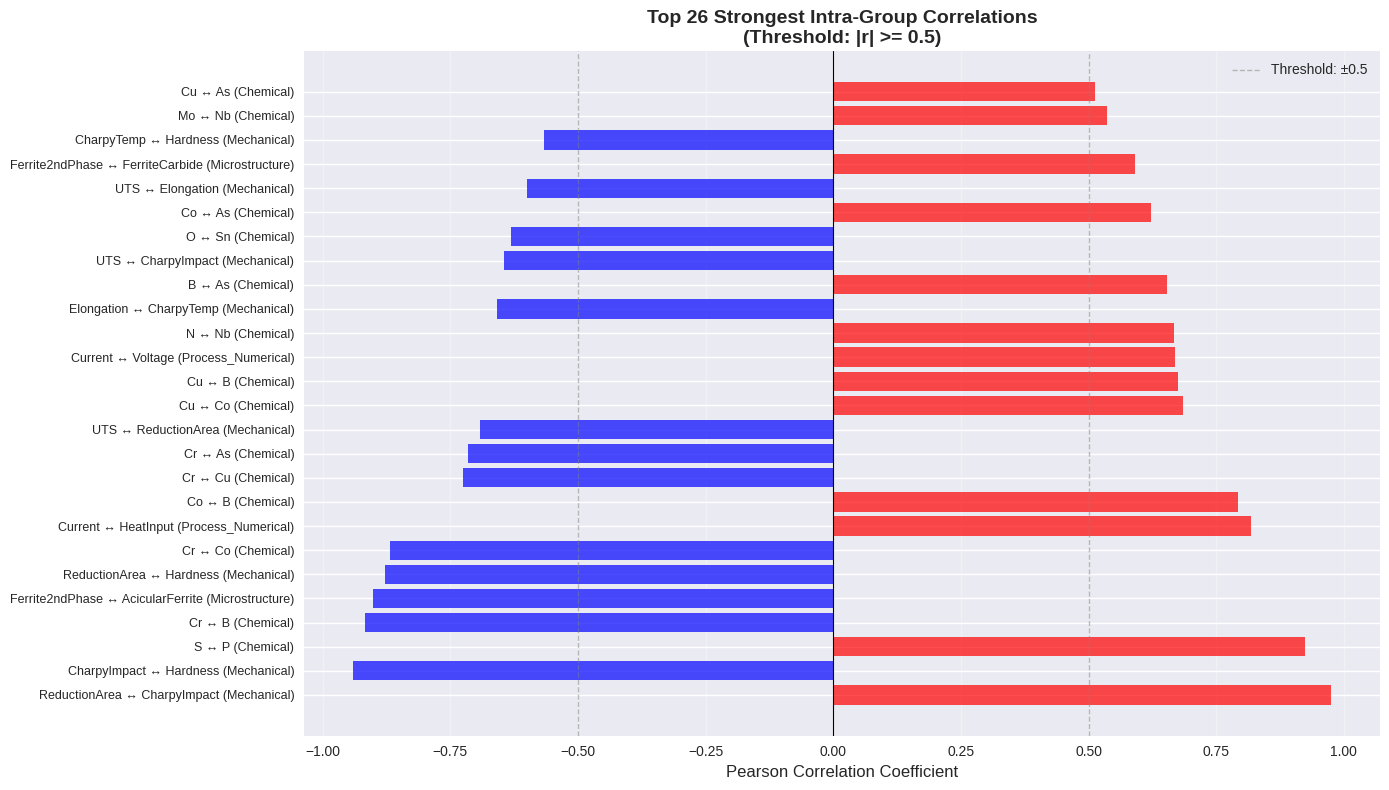


SUMMARY: Found 26 strong intra-group correlations (|r| >= 0.5)


In [38]:
# Find strong correlations within each group
threshold = 0.5  # Minimum absolute correlation to report
all_strong_intra_correlations = []

for group_name, group_cols in ALL_GROUPS.items():
    # Filter to only existing columns
    existing_cols = [col for col in group_cols if col in corr_matrix_full.columns]
    
    if len(existing_cols) < 2:
        continue
    
    # Get correlation matrix for this group
    group_corr = corr_matrix_full.loc[existing_cols, existing_cols]
    
    # Find strong correlations (upper triangle only)
    strong_corr = []
    for i, col1 in enumerate(existing_cols):
        for j, col2 in enumerate(existing_cols):
            if i < j:  # Upper triangle only
                corr_value = group_corr.loc[col1, col2]
                if abs(corr_value) >= threshold:
                    strong_corr.append({
                        'Group': group_name,
                        'Variable1': col1,
                        'Variable2': col2,
                        'Correlation': corr_value,
                        'Abs_Correlation': abs(corr_value)
                    })
    
    if len(strong_corr) > 0:
        all_strong_intra_correlations.extend(strong_corr)
        print(f"\n{group_name} Group - Strong Correlations (|r| >= {threshold}):")
        print("-" * 80)
        strong_df = pd.DataFrame(strong_corr).sort_values('Abs_Correlation', ascending=False)
        for _, row in strong_df.iterrows():
            print(f"  {row['Variable1']:<20} ↔ {row['Variable2']:<20} : r = {row['Correlation']:7.3f}")
        print(f"  Total: {len(strong_corr)} strong correlations")

# Handle unassigned columns
if len(missing_cols) > 0:
    unassigned_cols = [col for col in missing_cols if col in corr_matrix_full.columns]
    if len(unassigned_cols) >= 2:
        unassigned_corr = corr_matrix_full.loc[unassigned_cols, unassigned_cols]
        strong_corr = []
        for i, col1 in enumerate(unassigned_cols):
            for j, col2 in enumerate(unassigned_cols):
                if i < j:
                    corr_value = unassigned_corr.loc[col1, col2]
                    if abs(corr_value) >= threshold:
                        strong_corr.append({
                            'Group': 'Unassigned',
                            'Variable1': col1,
                            'Variable2': col2,
                            'Correlation': corr_value,
                            'Abs_Correlation': abs(corr_value)
                        })
        
        if len(strong_corr) > 0:
            all_strong_intra_correlations.extend(strong_corr)
            print(f"\nUnassigned Columns - Strong Correlations (|r| >= {threshold}):")
            print("-" * 80)
            strong_df = pd.DataFrame(strong_corr).sort_values('Abs_Correlation', ascending=False)
            for _, row in strong_df.iterrows():
                print(f"  {row['Variable1']:<20} ↔ {row['Variable2']:<20} : r = {row['Correlation']:7.3f}")
            print(f"  Total: {len(strong_corr)} strong correlations")

# Create visualization of all strong intra-group correlations
if len(all_strong_intra_correlations) > 0:
    all_strong_df = pd.DataFrame(all_strong_intra_correlations).sort_values('Abs_Correlation', ascending=False)
    
    # Plot top correlations
    top_n = min(30, len(all_strong_df))
    top_corr = all_strong_df.head(top_n)
    
    plt.figure(figsize=(14, max(8, top_n * 0.3)))
    y_pos = np.arange(len(top_corr))
    colors = ['red' if c > 0 else 'blue' for c in top_corr['Correlation']]
    
    plt.barh(y_pos, top_corr['Correlation'], color=colors, alpha=0.7)
    plt.yticks(y_pos, [f"{row['Variable1']} ↔ {row['Variable2']} ({row['Group']})" 
                       for _, row in top_corr.iterrows()], fontsize=9)
    plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
    plt.title(f'Top {top_n} Strongest Intra-Group Correlations\n(Threshold: |r| >= {threshold})', 
              fontsize=14, weight='bold')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.axvline(x=threshold, color='gray', linestyle='--', linewidth=1, alpha=0.5, label=f'Threshold: ±{threshold}')
    plt.axvline(x=-threshold, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: Found {len(all_strong_intra_correlations)} strong intra-group correlations (|r| >= {threshold})")
    print("="*80)
else:
    print(f"\nNo strong intra-group correlations found with threshold |r| >= {threshold}")


## PCA Application: Dimensionality Reduction by Groups

### Objective and Procedure

This section applies **independent PCA (Principal Component Analysis) on each group of variables** to reduce dimensionality while retaining 90% of the explained variance.

#### Procedure in 4 steps:

1. **Data Preparation**:
   - Load normalized datasets (train and test)
   - Define column groups (Chemical, Mechanical, Process_Numerical, Microstructure)
   - Identify post-weld columns (data leakage)

2. **Two PCA Versions**:
   - **Version 1 - With post-weld columns**: All numerical columns
   - **Version 2 - Without post-weld columns**: Exclude mechanical and microstructure columns (measured after welding)

3. **Group-wise Processing**:
   - For each group, center the data (mean=0)
   - Independent PCA with 90% variance retained
   - Fit on train, transform on train and test
   - Preserve categorical columns (already encoded) and target

4. **Save Results**:
   - Transformed datasets saved in `data/`
   - File names: `train_pca_with_postweld.csv`, `test_pca_with_postweld.csv`, etc.

#### Post-weld columns (to exclude in version 2):
- **Mechanical**: UTS, Elongation, ReductionArea, CharpyTemp, CharpyImpact, Hardness, FATT50
- **Microstructure**: PrimaryFerrite, Ferrite2ndPhase, AcicularFerrite, Martensite, FerriteCarbide


In [41]:
# Import the PCA preprocessing function
import sys
sys.path.append('../src/preprocessing')
from pca_preprocessing import apply_pca_by_groups

# Load normalized datasets
train_df = pd.read_csv("../data/train_normalised.csv")
test_df = pd.read_csv("../data/test_normalised.csv")

print("="*80)
print("DATASET LOADING")
print("="*80)
print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Train columns: {train_df.columns.tolist()[:10]}... ({len(train_df.columns)} total)")
print("="*80)


DATASET LOADING
Train shape: (1500, 52)
Test shape: (152, 52)
Train columns: ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu']... (52 total)


### Define Groups and Post-Weld Columns


In [42]:
# Define column groups (same as in correlation analysis)
CHEM_COLS = [
    'C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co',
    'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb'
]

MECH_COLS = [
    'UTS', 'Elongation', 'ReductionArea',
    'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
]

PROC_NUM_COLS = [
    'Current', 'Voltage', 'HeatInput', 'InterpassTemp'
]

MICRO_COLS = [
    'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 
    'Martensite', 'FerriteCarbide'
]

# Define post-weld columns (data leakage - measured after welding)
POST_WELD_COLS = MECH_COLS + MICRO_COLS

# Filter groups to only include columns that exist in the dataset
CHEM_COLS = [col for col in CHEM_COLS if col in train_df.columns]
MECH_COLS = [col for col in MECH_COLS if col in train_df.columns]
PROC_NUM_COLS = [col for col in PROC_NUM_COLS if col in train_df.columns]
MICRO_COLS = [col for col in MICRO_COLS if col in train_df.columns]
POST_WELD_COLS = [col for col in POST_WELD_COLS if col in train_df.columns]

print("="*80)
print("COLUMN GROUPS DEFINITION")
print("="*80)
print(f"Chemical columns: {len(CHEM_COLS)} columns")
print(f"  {CHEM_COLS}")
print(f"\nMechanical columns (post-weld): {len(MECH_COLS)} columns")
print(f"  {MECH_COLS}")
print(f"\nProcess Numerical columns: {len(PROC_NUM_COLS)} columns")
print(f"  {PROC_NUM_COLS}")
print(f"\nMicrostructure columns (post-weld): {len(MICRO_COLS)} columns")
print(f"  {MICRO_COLS}")
print(f"\nTotal post-weld columns: {len(POST_WELD_COLS)}")
print(f"  {POST_WELD_COLS}")
print("="*80)


COLUMN GROUPS DEFINITION
Chemical columns: 21 columns
  ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb']

Mechanical columns (post-weld): 7 columns
  ['UTS', 'Elongation', 'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50']

Process Numerical columns: 4 columns
  ['Current', 'Voltage', 'HeatInput', 'InterpassTemp']

Microstructure columns (post-weld): 5 columns
  ['PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite', 'FerriteCarbide']

Total post-weld columns: 12
  ['UTS', 'Elongation', 'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50', 'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Martensite', 'FerriteCarbide']


### Version 1: PCA with All Columns (Including Post-Weld)


In [44]:
# Version 1: All columns (including post-weld)
column_groups_with_postweld = [
    CHEM_COLS,
    MECH_COLS,
    PROC_NUM_COLS,
    MICRO_COLS
]

print("="*80)
print("VERSION 1: PCA WITH POST-WELD COLUMNS")
print("="*80)
print("Applying PCA to all groups including post-weld measurements...")
print("="*80)

train_pca_with_postweld, test_pca_with_postweld, pca_info_with_postweld = apply_pca_by_groups(
    train_df=train_df,
    test_df=test_df,
    column_groups=column_groups_with_postweld,
    group_names=['Chemical', 'Mechanical', 'Process_Numerical', 'Microstructure'],
    target_col="YieldStrength",
    variance_retained=0.90,
    center_only=True  # Only center, don't scale
)


VERSION 1: PCA WITH POST-WELD COLUMNS
Applying PCA to all groups including post-weld measurements...
PCA BY GROUPS - PROCESSING
Target column: YieldStrength
Variance retained: 90.0%
Scaling mode: Center only (mean=0)
Categorical columns preserved: 14

Chemical: 21 columns
  Columns: ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb']
  Original columns: 21
  PCA components: 8
  Columns removed: 13
  Variance explained: 91.44%

Mechanical: 7 columns
  Columns: ['UTS', 'Elongation', 'ReductionArea', 'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50']
  Original columns: 7
  PCA components: 3
  Columns removed: 4
  Variance explained: 95.26%

Process_Numerical: 4 columns
  Columns: ['Current', 'Voltage', 'HeatInput', 'InterpassTemp']
  Original columns: 4
  PCA components: 2
  Columns removed: 2
  Variance explained: 99.85%

Microstructure: 5 columns
  Columns: ['PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite', 'Mart

### Version 2: PCA without Post-Weld Columns (to Avoid Data Leakage)


In [45]:
# Version 2: Exclude post-weld columns (no data leakage)
# Only Chemical and Process Numerical columns
column_groups_without_postweld = [
    CHEM_COLS,
    PROC_NUM_COLS
]

print("="*80)
print("VERSION 2: PCA WITHOUT POST-WELD COLUMNS")
print("="*80)
print("Applying PCA to Chemical and Process Numerical groups only...")
print("Excluding: Mechanical and Microstructure columns (post-weld measurements)")
print("="*80)

train_pca_without_postweld, test_pca_without_postweld, pca_info_without_postweld = apply_pca_by_groups(
    train_df=train_df,
    test_df=test_df,
    column_groups=column_groups_without_postweld,
    group_names=['Chemical', 'Process_Numerical'],
    target_col="YieldStrength",
    variance_retained=0.90,
    center_only=True  # Only center, don't scale
)


VERSION 2: PCA WITHOUT POST-WELD COLUMNS
Applying PCA to Chemical and Process Numerical groups only...
Excluding: Mechanical and Microstructure columns (post-weld measurements)
PCA BY GROUPS - PROCESSING
Target column: YieldStrength
Variance retained: 90.0%
Scaling mode: Center only (mean=0)
Categorical columns preserved: 14

Chemical: 21 columns
  Columns: ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O', 'Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb']
  Original columns: 21
  PCA components: 8
  Columns removed: 13
  Variance explained: 91.44%

Process_Numerical: 4 columns
  Columns: ['Current', 'Voltage', 'HeatInput', 'InterpassTemp']
  Original columns: 4
  PCA components: 2
  Columns removed: 2
  Variance explained: 99.85%

PCA SUMMARY
Total original columns: 25
Total reduced columns: 10
Total columns removed: 15
Reduction: 15/25 = 60.0%
Final train shape: (1500, 25)
Final test shape: (152, 25)


### Comparison of the Two Versions


In [46]:
print("="*80)
print("COMPARISON: WITH vs WITHOUT POST-WELD COLUMNS")
print("="*80)

print("\n📊 VERSION 1 - WITH POST-WELD COLUMNS:")
print(f"  Train shape: {train_pca_with_postweld.shape}")
print(f"  Test shape: {test_pca_with_postweld.shape}")
print(f"  Original columns: {pca_info_with_postweld['total_original_cols']}")
print(f"  Reduced columns: {pca_info_with_postweld['total_reduced_cols']}")
print(f"  Columns removed: {pca_info_with_postweld['total_cols_removed']}")
print(f"  Reduction: {pca_info_with_postweld['total_cols_removed']/pca_info_with_postweld['total_original_cols']*100:.1f}%")

print("\n📊 VERSION 2 - WITHOUT POST-WELD COLUMNS:")
print(f"  Train shape: {train_pca_without_postweld.shape}")
print(f"  Test shape: {test_pca_without_postweld.shape}")
print(f"  Original columns: {pca_info_without_postweld['total_original_cols']}")
print(f"  Reduced columns: {pca_info_without_postweld['total_reduced_cols']}")
print(f"  Columns removed: {pca_info_without_postweld['total_cols_removed']}")
print(f"  Reduction: {pca_info_without_postweld['total_cols_removed']/pca_info_without_postweld['total_original_cols']*100:.1f}%")

print("\n" + "="*80)
print("COLUMN BREAKDOWN:")
print("="*80)
print("\nVersion 1 columns:")
print(f"  - PCA components: {len([c for c in train_pca_with_postweld.columns if 'PC' in c])}")
print(f"  - Categorical: {len([c for c in train_pca_with_postweld.columns if any(prefix in c for prefix in ['AC_DC', 'ElectrodePolarity', 'WeldType'])])}")
print(f"  - Target: {1 if 'YieldStrength' in train_pca_with_postweld.columns else 0}")

print("\nVersion 2 columns:")
print(f"  - PCA components: {len([c for c in train_pca_without_postweld.columns if 'PC' in c])}")
print(f"  - Categorical: {len([c for c in train_pca_without_postweld.columns if any(prefix in c for prefix in ['AC_DC', 'ElectrodePolarity', 'WeldType'])])}")
print(f"  - Target: {1 if 'YieldStrength' in train_pca_without_postweld.columns else 0}")
print("="*80)


COMPARISON: WITH vs WITHOUT POST-WELD COLUMNS

📊 VERSION 1 - WITH POST-WELD COLUMNS:
  Train shape: (1500, 31)
  Test shape: (152, 31)
  Original columns: 37
  Reduced columns: 16
  Columns removed: 21
  Reduction: 56.8%

📊 VERSION 2 - WITHOUT POST-WELD COLUMNS:
  Train shape: (1500, 25)
  Test shape: (152, 25)
  Original columns: 25
  Reduced columns: 10
  Columns removed: 15
  Reduction: 60.0%

COLUMN BREAKDOWN:

Version 1 columns:
  - PCA components: 16
  - Categorical: 14
  - Target: 1

Version 2 columns:
  - PCA components: 10
  - Categorical: 14
  - Target: 1


### Save Transformed Datasets


In [47]:
# Save Version 1: With post-weld columns
train_pca_with_postweld.to_csv("../data/train_pca_with_postweld.csv", index=False)
test_pca_with_postweld.to_csv("../data/test_pca_with_postweld.csv", index=False)

print("✅ Version 1 saved:")
print(f"  - train_pca_with_postweld.csv ({train_pca_with_postweld.shape})")
print(f"  - test_pca_with_postweld.csv ({test_pca_with_postweld.shape})")

# Save Version 2: Without post-weld columns
train_pca_without_postweld.to_csv("../data/train_pca_without_postweld.csv", index=False)
test_pca_without_postweld.to_csv("../data/test_pca_without_postweld.csv", index=False)

print("\n✅ Version 2 saved:")
print(f"  - train_pca_without_postweld.csv ({train_pca_without_postweld.shape})")
print(f"  - test_pca_without_postweld.csv ({test_pca_without_postweld.shape})")

print("\n" + "="*80)
print("PCA PREPROCESSING COMPLETED SUCCESSFULLY!")
print("="*80)


✅ Version 1 saved:
  - train_pca_with_postweld.csv ((1500, 31))
  - test_pca_with_postweld.csv ((152, 31))

✅ Version 2 saved:
  - train_pca_without_postweld.csv ((1500, 25))
  - test_pca_without_postweld.csv ((152, 25))

PCA PREPROCESSING COMPLETED SUCCESSFULLY!
